### Install Requirements

In [1]:
# !pip install positional-encodings[pytorch]
# !pip install pyvis
# from google.colab import output
# output.enable_custom_widget_manager()

### Import Libraries

In [2]:
from positional_encodings.torch_encodings import *
import numpy as np
import random
import networkx as nx
from collections import defaultdict
import pandas as pd

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

from pyvis.network import Network
from IPython.display import display, HTML
import hashlib

from triangles_auxiliary_functions import generate_random_graphs, moving_average, show_graph_with_labels, get_unique_adj_matrices
from triangles_generation_functions import generate_dataset, generate_non_isomorphic_graphs, plot_graphs, generate_unique_random_graphs_with_triangles, generate_isomorphic_graphs
from statistics_helper_functions import calculate_graph_metrics, summarize_dataset_metrics, create_visualizations
from attention_analysis_functions import visualize_single_edge_attention, visualize_edge_attention, get_correct_example

### Traditional Positional Encoding

#### 2D

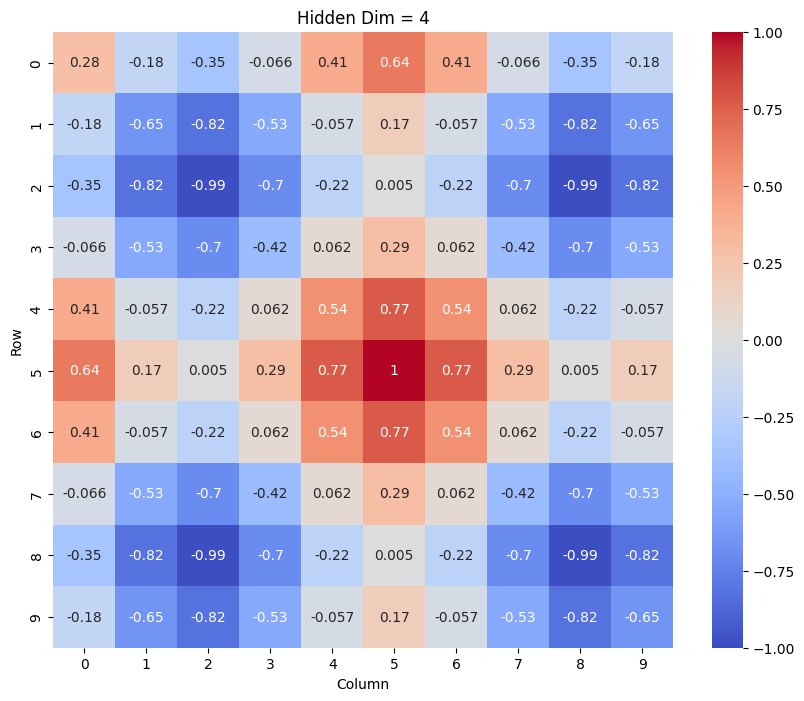

In [3]:
hidden_dim = 4
n_nodes = 10
p_enc_2d = Summer(PositionalEncoding2D(hidden_dim))
todos = p_enc_2d(torch.zeros([1, n_nodes, n_nodes, hidden_dim]))
mitad  = p_enc_2d(torch.zeros([1, n_nodes, n_nodes, hidden_dim]))[:, n_nodes//2, n_nodes//2, :]

# Create example tensors
tensor1 = todos
tensor2 = mitad

# Reshape tensor1 to (1, 25, 5) for easier computation
tensor1_reshaped = tensor1.view(1, n_nodes**2, hidden_dim)

# Compute cosine similarity
cosine_sim = F.cosine_similarity(tensor1_reshaped, tensor2.unsqueeze(1), dim=2)

# Reshape the result to (5, 5) for heatmap
cosine_sim_reshaped = cosine_sim.view(n_nodes, n_nodes)

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim_reshaped.detach().numpy(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title(f'Hidden Dim = {hidden_dim}')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()

#### 1D

torch.Size([1, 100, 32])


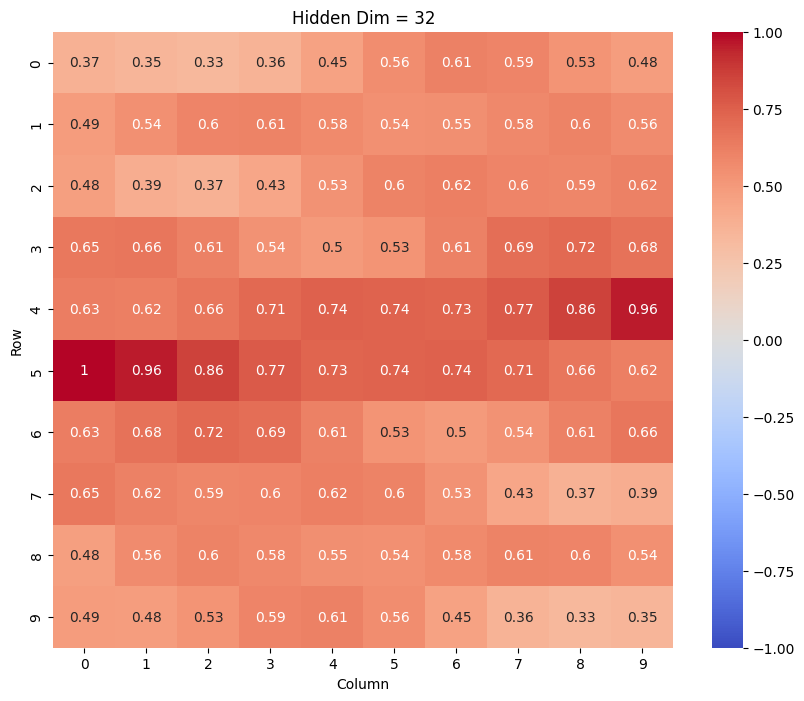

In [4]:
hidden_dim = 32
n_nodes = 10
p_enc_2d = Summer(PositionalEncoding1D(hidden_dim))
todos = p_enc_2d(torch.zeros([1, n_nodes*n_nodes, hidden_dim]))
print(todos.shape)
mitad  = todos[:, (n_nodes**2)//2, :]

# Create example tensors
tensor1 = todos
tensor2 = mitad

# Reshape tensor1 to (1, 25, 5) for easier computation
tensor1_reshaped = tensor1.view(1, n_nodes**2, hidden_dim)

# Compute cosine similarity
cosine_sim = F.cosine_similarity(tensor1_reshaped, tensor2.unsqueeze(1), dim=2)

# Reshape the result to (5, 5) for heatmap
cosine_sim_reshaped = cosine_sim.view(n_nodes, n_nodes)

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim_reshaped.detach().numpy(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title(f'Hidden Dim = {hidden_dim}')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()

### Vanilla Transformer

#### Transformer classes

In [5]:
class GraphTransformerClassifier(nn.Module):
    def __init__(self, max_nodes, hidden_dim, num_heads, num_layers, use_2d_encoding):
        super(GraphTransformerClassifier, self).__init__()
        self.max_nodes = max_nodes
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.use_2d_encoding = use_2d_encoding

        # Positional encoding
        if use_2d_encoding:
            self.pos_encoding = Summer(PositionalEncoding2D(hidden_dim))
        else:
            self.pos_encoding = Summer(PositionalEncoding1D(hidden_dim))

        # Initial transformation of adjacency matrix
        self.input_proj = nn.Linear(1, hidden_dim)

        # Graph Transformer layers
        self.layers = nn.ModuleList([
            GraphTransformerLayer(hidden_dim, num_heads)
            for _ in range(num_layers)
        ])

        # Binary classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )

    def forward(self, adj_matrix):
        # adj_matrix: [batch_size, num_nodes, num_nodes]
        batch_size, num_nodes, _ = adj_matrix.size()

        # Pad adjacency matrix if necessary
        if num_nodes < self.max_nodes:
            padding = torch.zeros(batch_size, self.max_nodes - num_nodes, num_nodes, device=adj_matrix.device)
            adj_matrix = torch.cat([adj_matrix, padding], dim=1)
            padding = torch.zeros(batch_size, self.max_nodes, self.max_nodes - num_nodes, device=adj_matrix.device)
            adj_matrix = torch.cat([adj_matrix, padding], dim=2)

        # Initial projection of adjacency matrix
        x = self.input_proj(adj_matrix.unsqueeze(-1))  # [batch_size, max_nodes, max_nodes, hidden_dim]

        if self.use_2d_encoding:
            # Add 2D positional encoding
            x = self.pos_encoding(x)
        else:
            # Reshape and add 1D positional encoding
            x = x.view(batch_size, self.max_nodes * self.max_nodes, self.hidden_dim)
            x = self.pos_encoding(x)

        # Reshape for transformer layers
        x = x.view(batch_size, self.max_nodes * self.max_nodes, self.hidden_dim)

        # Create attention mask
        attention_mask = adj_matrix.view(batch_size, self.max_nodes * self.max_nodes)
        attention_mask = attention_mask.unsqueeze(1).repeat(1, self.max_nodes * self.max_nodes, 1)
        attention_mask = (attention_mask == 0).float()
        attention_mask = attention_mask.repeat(self.num_heads, 1, 1)

        # Apply Graph Transformer layers
        attention_weights = []
        for layer in self.layers:
            x, attn_weights = layer(x, attention_mask)
            attention_weights.append(attn_weights)

        # Global mean pooling
        graph_embedding = x.mean(dim=1)

        # Binary classification
        output = self.classifier(graph_embedding)

        return output.squeeze(), attention_weights


In [6]:
class GraphTransformerLayer(nn.Module):
    def __init__(self, hidden_dim, num_heads):
        super(GraphTransformerLayer, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads

        # Multi-head attention
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads)

        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim)
        )

        # Layer normalization
        self.layer_norm1 = nn.LayerNorm(hidden_dim)
        self.layer_norm2 = nn.LayerNorm(hidden_dim)

    def forward(self, x, attention_mask):
        # x: node features [batch_size, max_nodes * max_nodes, hidden_dim]
        # attention_mask: [num_heads * batch_size, max_nodes * max_nodes, max_nodes * max_nodes]

        # Reshape for multi-head attention
        q = x.transpose(0, 1)
        k = x.transpose(0, 1)
        v = x.transpose(0, 1)

        # Compute attention scores
        attn_output, attn_weights = self.attention(q, k, v, attn_mask=attention_mask)
        attn_output = attn_output.transpose(0, 1)

        # Residual connection and layer norm
        x = x + attn_output
        x = self.layer_norm1(x)

        # Feed-forward network
        ff_output = self.ffn(x)

        # Residual connection and layer norm
        x = x + ff_output
        x = self.layer_norm2(x)

        return x, attn_weights

#### Using 2D Positional Encoding

In [7]:
# Example usage
max_nodes = 5
hidden_dim = 32
num_heads = 1
num_layers = 3
model = GraphTransformerClassifier(max_nodes, hidden_dim, num_heads, num_layers, True)

# Create a sample adjacency matrix (batch_size=1, num_nodes=5)
adj_matrix = torch.tensor([[[0, 1, 1, 0, 0],
                            [1, 0, 1, 0, 0],
                            [1, 1, 0, 0, 0],
                            [0, 0, 0, 0, 1],
                            [0, 0, 0, 1, 0]]], dtype=torch.float32)

output, attn_weights = model(adj_matrix)
print(f"Output: {output.item()}")

Output: 0.39452749490737915


#### Using 1D Positional Encoding

In [8]:
# Example usage
max_nodes = 5
hidden_dim = 32
num_heads = 1
num_layers = 3
model = GraphTransformerClassifier(max_nodes, hidden_dim, num_heads, num_layers, False)

# Create a sample adjacency matrix (batch_size=1, num_nodes=5)
adj_matrix = torch.tensor([[[0, 1, 1, 0, 0],
                            [1, 0, 1, 0, 0],
                            [1, 1, 0, 0, 0],
                            [0, 0, 0, 0, 1],
                            [0, 0, 0, 1, 0]]], dtype=torch.float32)

output, attn_weights = model(adj_matrix)
print(f"Output: {output.item()}")

Output: 0.47954457998275757


#### Using Learnable Embedding Table

In [9]:
class GraphTransformerClassifierET(nn.Module):
    def __init__(self, max_nodes, hidden_dim, num_heads, num_layers):
        super(GraphTransformerClassifierET, self).__init__()
        self.max_nodes = max_nodes
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.num_layers = num_layers

        # Learnable embedding table
        self.embedding_table = nn.Embedding(max_nodes * max_nodes, hidden_dim)

        # Initial transformation of adjacency matrix
        self.input_proj = nn.Linear(1, hidden_dim)

        # Graph Transformer layers
        self.layers = nn.ModuleList([
            GraphTransformerLayer(hidden_dim, num_heads)
            for _ in range(num_layers)
        ])

        # Binary classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )

    def forward(self, adj_matrix):
        # adj_matrix: [batch_size, num_nodes, num_nodes]
        batch_size, num_nodes, _ = adj_matrix.size()

        # Pad adjacency matrix if necessary
        if num_nodes < self.max_nodes:
            padding = torch.zeros(batch_size, self.max_nodes - num_nodes, num_nodes, device=adj_matrix.device)
            adj_matrix = torch.cat([adj_matrix, padding], dim=1)
            padding = torch.zeros(batch_size, self.max_nodes, self.max_nodes - num_nodes, device=adj_matrix.device)
            adj_matrix = torch.cat([adj_matrix, padding], dim=2)

        # Initial projection of adjacency matrix
        x = self.input_proj(adj_matrix.unsqueeze(-1))  # [batch_size, max_nodes, max_nodes, hidden_dim]

        # Add learnable embeddings
        position_ids = torch.arange(self.max_nodes * self.max_nodes, device=x.device).unsqueeze(0).expand(batch_size, -1)
        position_embeddings = self.embedding_table(position_ids).view(batch_size, self.max_nodes, self.max_nodes, self.hidden_dim)
        x = x + position_embeddings

        # Reshape for transformer layers
        x = x.view(batch_size, self.max_nodes * self.max_nodes, self.hidden_dim)

        # Create attention mask
        attention_mask = adj_matrix.view(batch_size, self.max_nodes * self.max_nodes)
        attention_mask = attention_mask.unsqueeze(1).repeat(1, self.max_nodes * self.max_nodes, 1)
        attention_mask = (attention_mask == 0).float()
        attention_mask = attention_mask.repeat(self.num_heads, 1, 1)

        # Apply Graph Transformer layers
        attention_weights = []
        for layer in self.layers:
            x, attn_weights = layer(x, attention_mask)
            attention_weights.append(attn_weights)

        # Global mean pooling
        graph_embedding = x.mean(dim=1)

        # Binary classification
        output = self.classifier(graph_embedding)

        return output.squeeze(), attention_weights

# The GraphTransformerLayer class remains unchanged

# Example usage
max_nodes = 5
hidden_dim = 32
num_heads = 1
num_layers = 3
model = GraphTransformerClassifierET(max_nodes, hidden_dim, num_heads, num_layers)

# Create a sample adjacency matrix (batch_size=1, num_nodes=5)
adj_matrix = torch.tensor([[[0, 1, 1, 0, 0],
                            [1, 0, 1, 0, 0],
                            [1, 1, 0, 0, 0],
                            [0, 0, 0, 0, 1],
                            [0, 0, 0, 1, 0]]], dtype=torch.float32)

output, attn_weights = model(adj_matrix)
print(f"Output: {output.item()}")

Output: 0.48993760347366333


### Dataset 1 generation

In [10]:
num_nodes = 8
max_nodes = num_nodes
dataset_size_target = 200

graphs_with_triangle = generate_random_graphs(num_nodes=num_nodes, num_graphs=dataset_size_target//2, enforce_triangle=True)
graphs_without_triangle = generate_random_graphs(num_nodes=num_nodes, num_graphs=dataset_size_target//2, enforce_triangle=False)

adj_matrices = graphs_with_triangle + graphs_without_triangle

node_size_list= [5]
max_nodes = max(node_size_list)
dataset_size_target = 512

adj_matrices, labels = generate_dataset(dataset_size_target, node_size_list)
adj_matrices_1 = adj_matrices[list(map(bool,labels)), :, :]
adj_matrices_0 = adj_matrices[list(map(lambda x: bool(0**x),labels)), :, :]

Dataset Size: 375
With Triangle Size: 207
Without Triange Size: 168
Totals for each node size:
{5: {'with': 207, 'without': 168}}


### Visualization

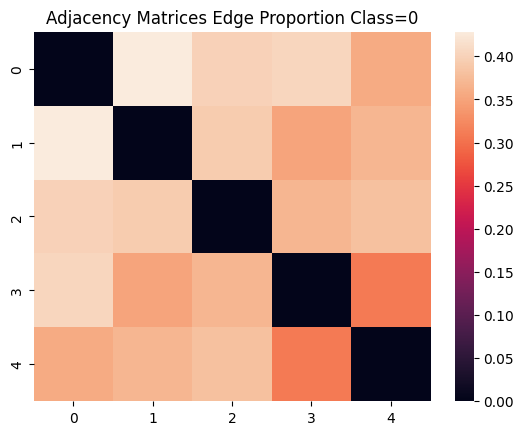

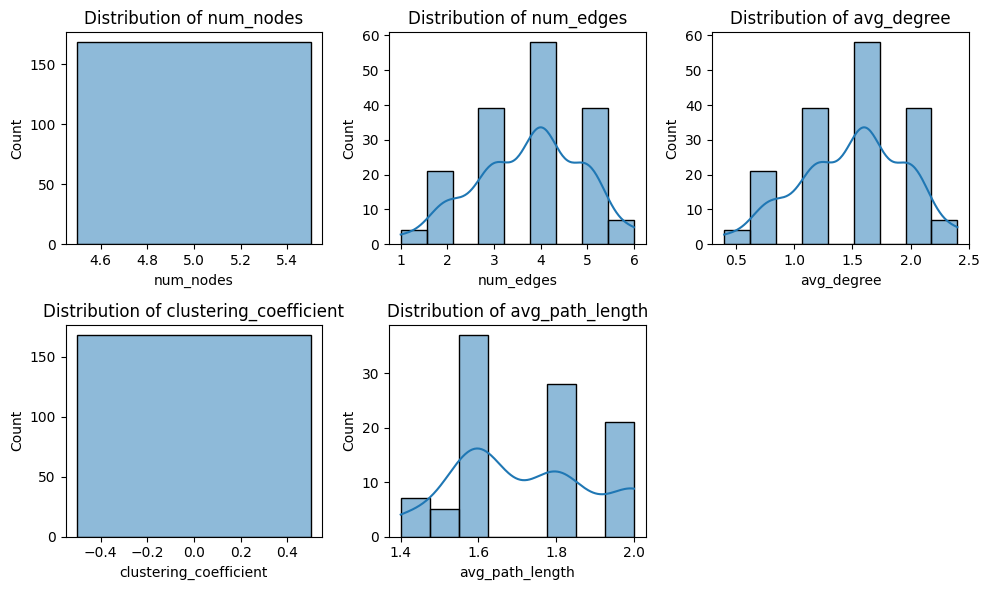

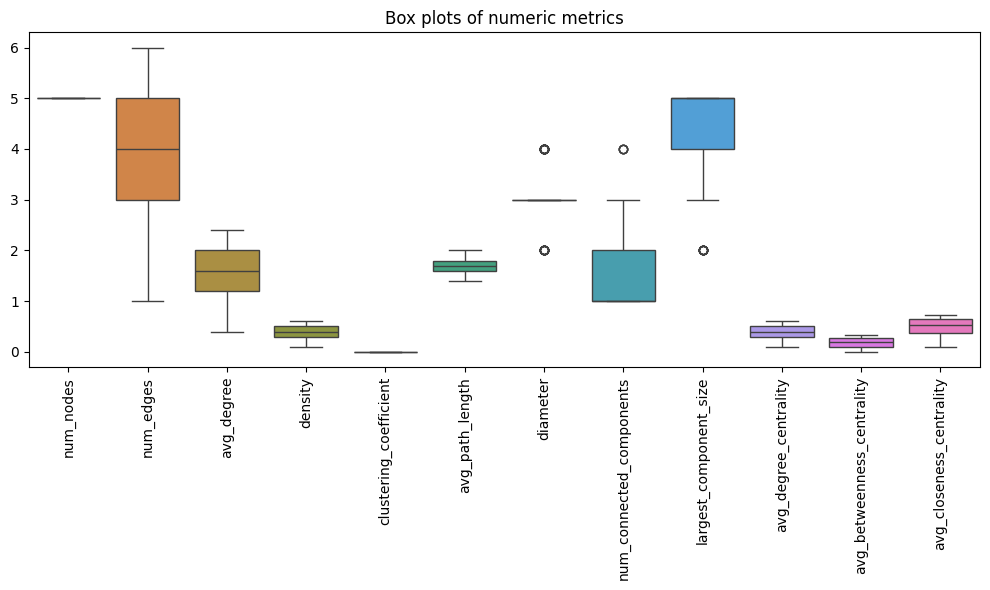

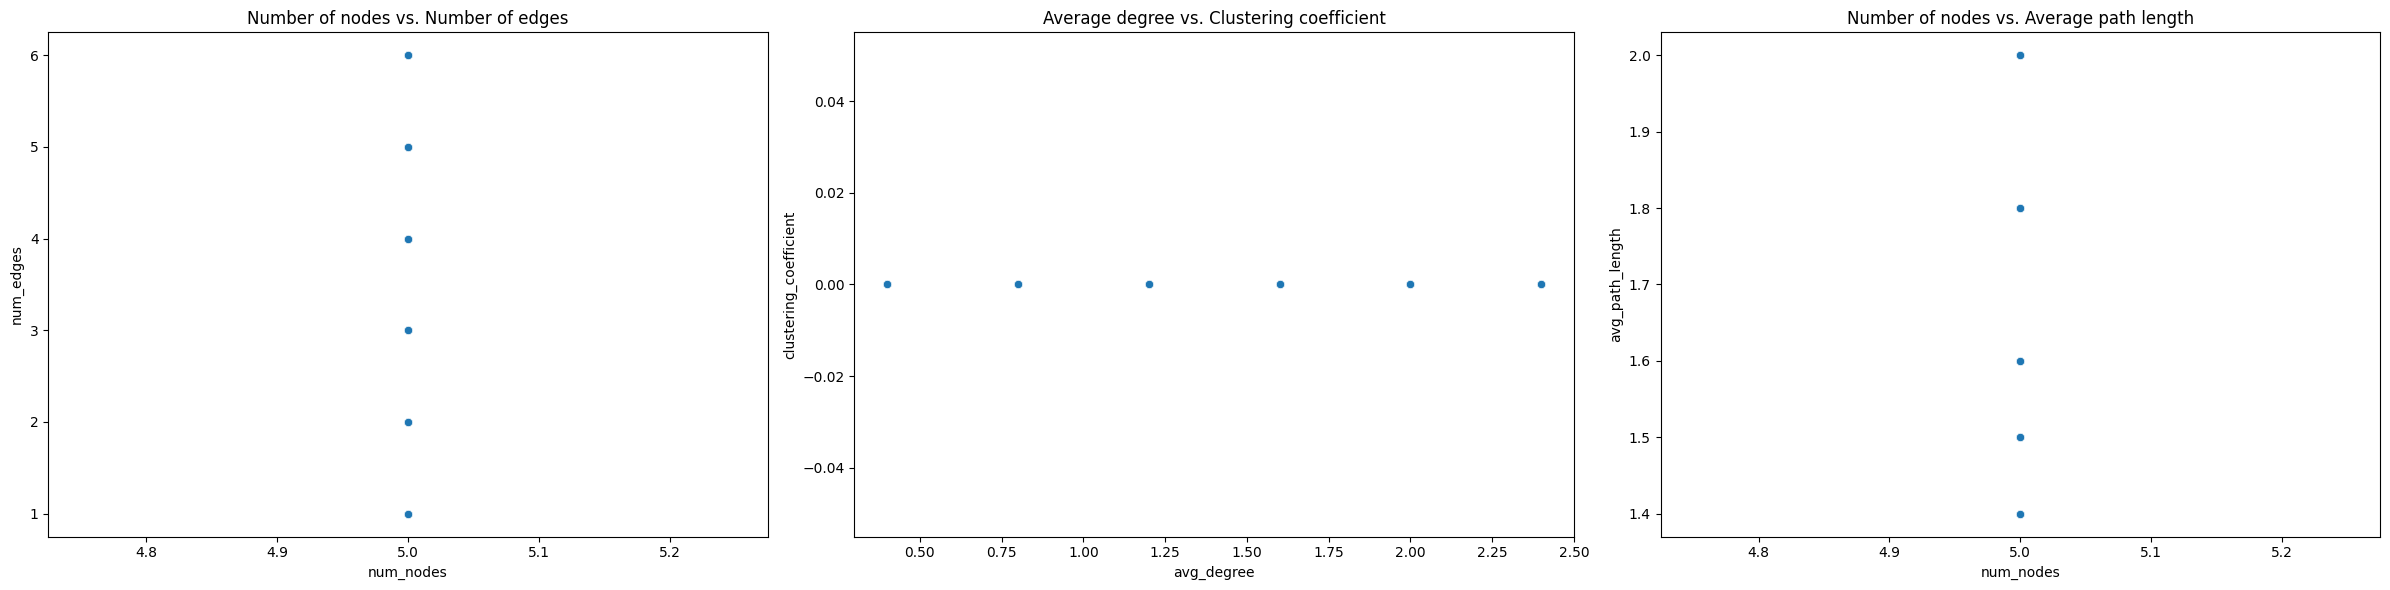

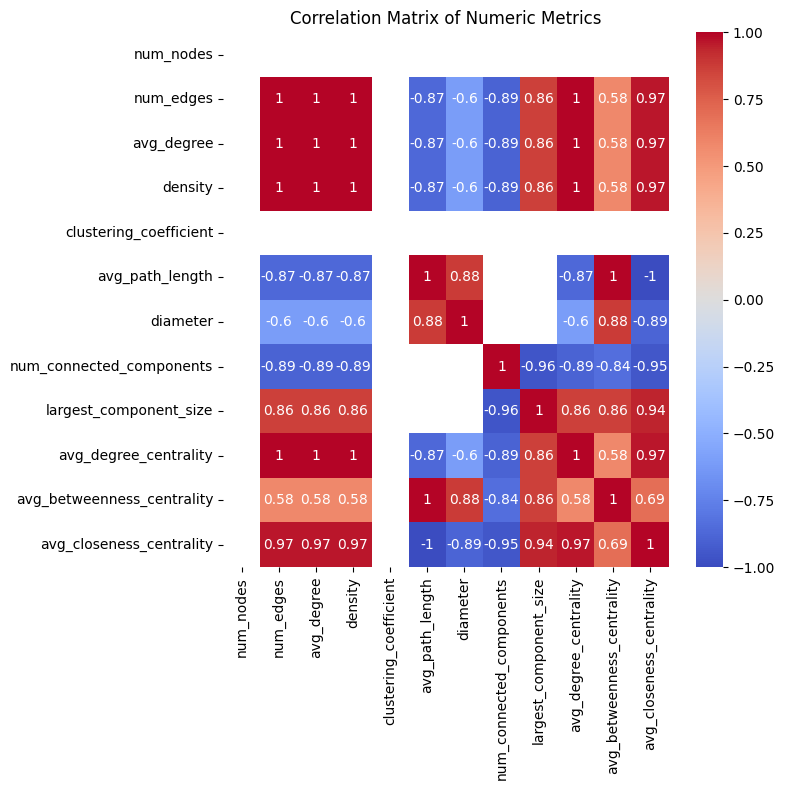

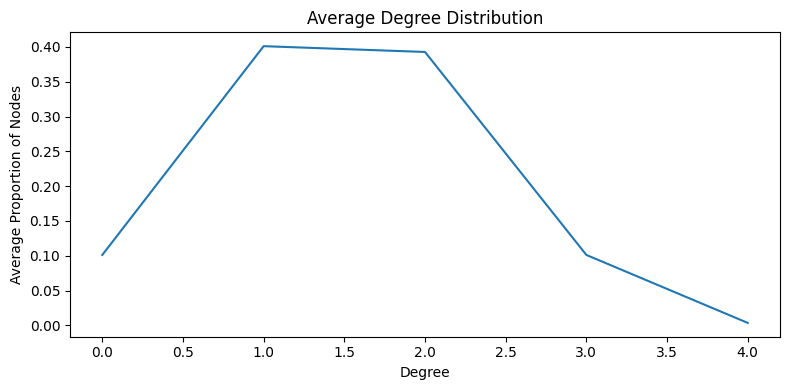

All visualizations have been displayed.


In [11]:
# Calculate metrics for each graph
individual_metrics = calculate_graph_metrics(adj_matrices_0)
# Calculate summary statistics for the dataset
dataset_summary = summarize_dataset_metrics(individual_metrics)
sns.heatmap(np.mean(adj_matrices_0, 0))
plt.title('Adjacency Matrices Edge Proportion Class=0')
# Create visualizations
create_visualizations(individual_metrics, dataset_summary)

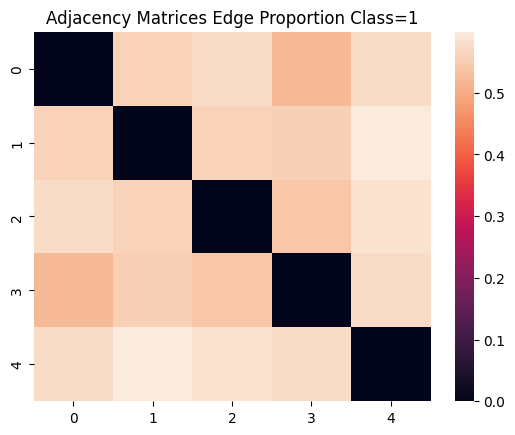

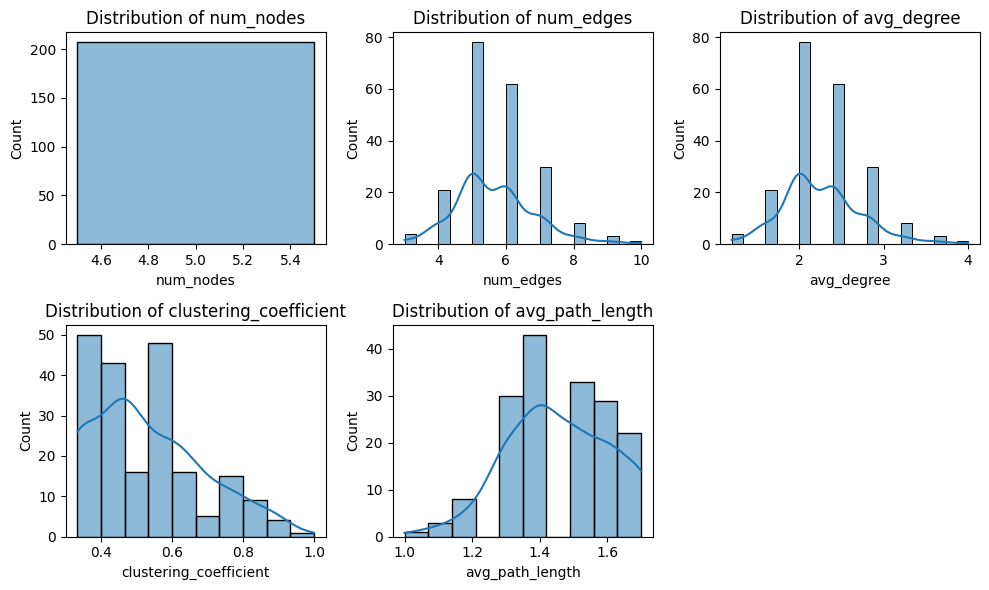

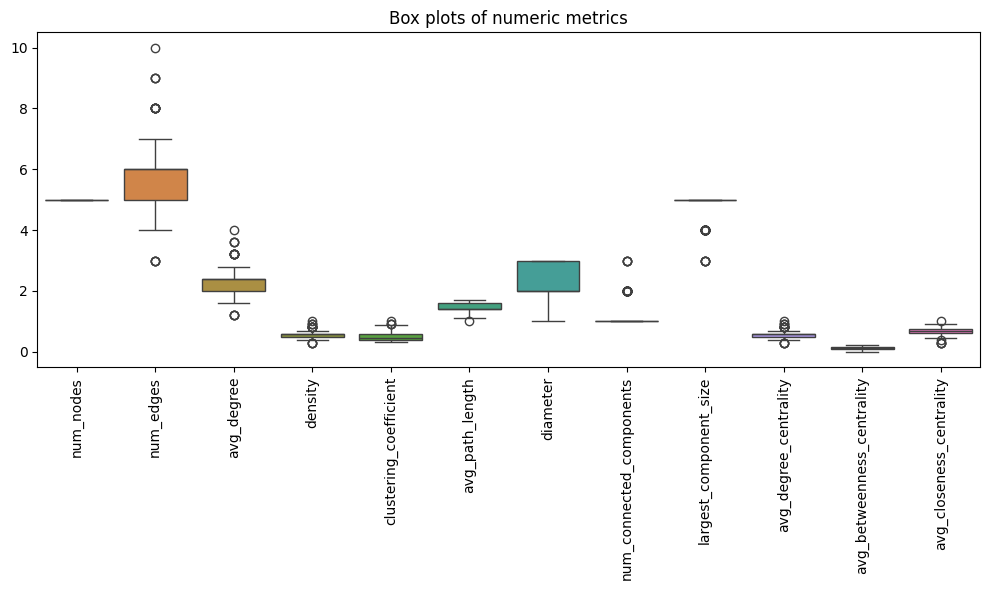

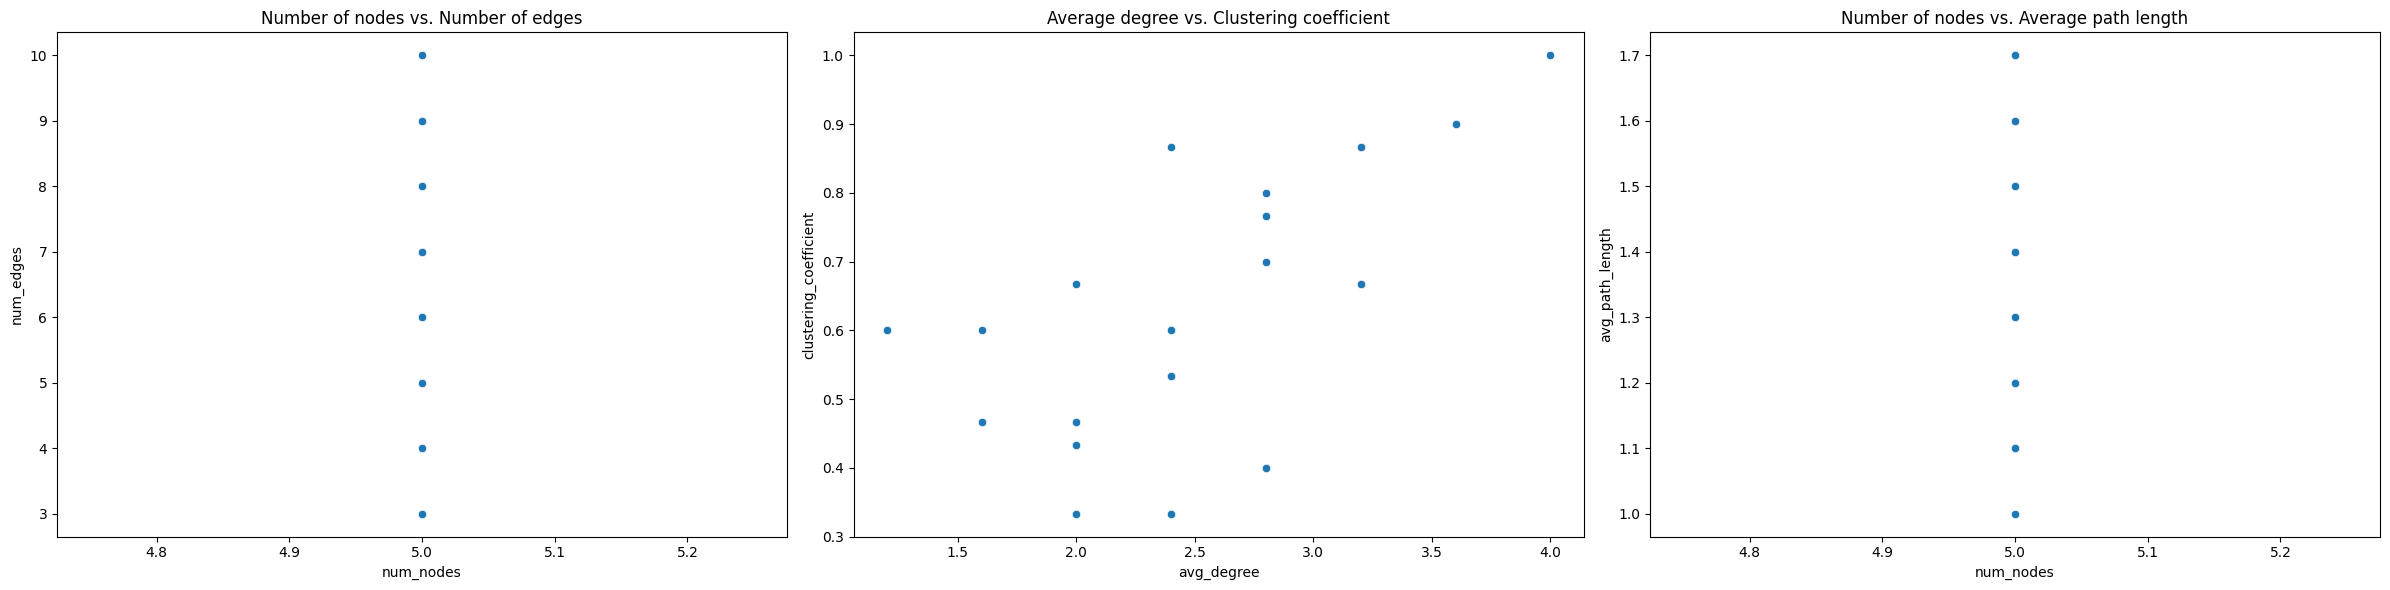

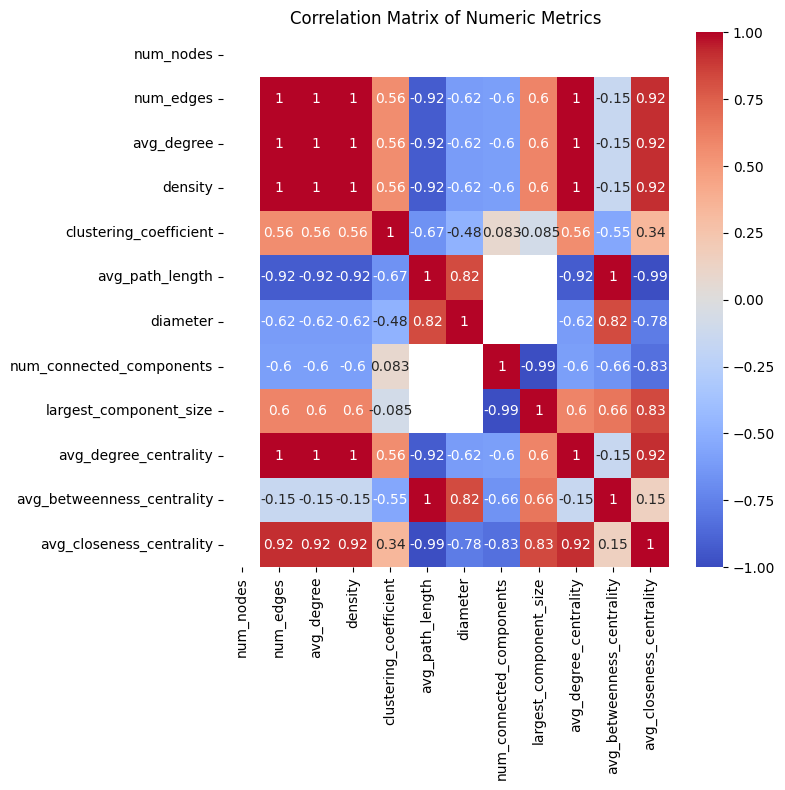

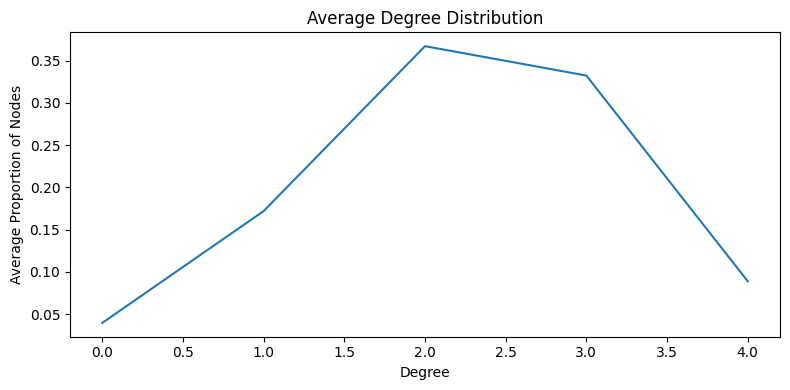

All visualizations have been displayed.


In [12]:
# Calculate metrics for each graph
individual_metrics = calculate_graph_metrics(adj_matrices_1)
# Calculate summary statistics for the dataset
dataset_summary = summarize_dataset_metrics(individual_metrics)
sns.heatmap(np.mean(adj_matrices_1, 0))
plt.title('Adjacency Matrices Edge Proportion Class=1')
# Create visualizations
create_visualizations(individual_metrics, dataset_summary)

### Training

In [13]:
class GraphDataset(Dataset):
    def __init__(self, adj_matrices, labels):
        self.adj_matrices = adj_matrices
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.adj_matrices[idx], self.labels[idx]

def collate_fn(batch):
    adj_matrices, labels = zip(*batch)

    # Find max number of nodes
    max_nodes = max(len(adj) for adj in adj_matrices)

    # Pad adjacency matrices
    padded_adj = []
    for adj in adj_matrices:
        pad_size = max_nodes - len(adj)
        padded = np.pad(adj, ((0, pad_size), (0, pad_size)), mode='constant')
        padded_adj.append(padded)

    # Convert to PyTorch tensors
    padded_adj = np.array(padded_adj)
    adj_tensor = torch.FloatTensor(padded_adj)

    labels_tensor = torch.FloatTensor(labels)

    return adj_tensor, labels_tensor

# adj_matrices: List of lists representing adjacency matrices
# labels: List of corresponding labels (0 or 1)

# Create dataset
dataset = GraphDataset(adj_matrices, labels)

# Create train-test split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Initialize model, loss function, and optimizer
hidden_dim = 32
num_heads = 1
num_layers = 1
lr = 1e-3
num_epochs = 1000

# 2D positional encoding
model = GraphTransformerClassifier(max_nodes, hidden_dim, num_heads, num_layers, True)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, epochs=num_epochs, steps_per_epoch=len(train_loader))


# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

accuracies = []
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for adj, labels in train_loader:
        adj, labels = adj.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, attention_w = model(adj)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for adj, labels in test_loader:
            adj, labels = adj.to(device), labels.to(device)
            outputs, attention_w = model(adj)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    if (epoch+1)%10 == 0:
      print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, '
            f'Val Loss: {val_loss/len(test_loader):.4f}, Accuracy: {100*correct/total:.2f}%')
    train_losses.append(round(train_loss/len(train_loader), 3))
    val_losses.append(round(val_loss/len(test_loader), 3))
    accuracies.append(round(100*correct/total, 3))

# Final test
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for adj, labels in test_loader:
        adj, labels = adj.to(device), labels.to(device)
        outputs, attention_w = model(adj)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Loss: {test_loss/len(test_loader):.4f}, Accuracy: {100*correct/total:.2f}%')

Epoch 10/1000, Train Loss: 0.6893, Val Loss: 0.6994, Accuracy: 54.67%
Epoch 20/1000, Train Loss: 0.6874, Val Loss: 0.7046, Accuracy: 54.67%
Epoch 30/1000, Train Loss: 0.6810, Val Loss: 0.7032, Accuracy: 54.67%
Epoch 40/1000, Train Loss: 0.6768, Val Loss: 0.6987, Accuracy: 54.67%
Epoch 50/1000, Train Loss: 0.6686, Val Loss: 0.6859, Accuracy: 54.67%
Epoch 60/1000, Train Loss: 0.6494, Val Loss: 0.6591, Accuracy: 60.00%
Epoch 70/1000, Train Loss: 0.6005, Val Loss: 0.5877, Accuracy: 72.00%
Epoch 80/1000, Train Loss: 0.5229, Val Loss: 0.4551, Accuracy: 88.00%
Epoch 90/1000, Train Loss: 0.4721, Val Loss: 0.3534, Accuracy: 88.00%
Epoch 100/1000, Train Loss: 0.4514, Val Loss: 0.3034, Accuracy: 88.00%
Epoch 110/1000, Train Loss: 0.4582, Val Loss: 0.2889, Accuracy: 88.00%
Epoch 120/1000, Train Loss: 0.4435, Val Loss: 0.2890, Accuracy: 88.00%
Epoch 130/1000, Train Loss: 0.4433, Val Loss: 0.2925, Accuracy: 88.00%
Epoch 140/1000, Train Loss: 0.4415, Val Loss: 0.2794, Accuracy: 88.00%
Epoch 150/1000,

In [14]:
# 1D positional encoding
model = GraphTransformerClassifier(max_nodes, hidden_dim, num_heads, num_layers, False)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, epochs=num_epochs, steps_per_epoch=len(train_loader))


# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

accuracies = []
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for adj, labels in train_loader:
        adj, labels = adj.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, attention_w = model(adj)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for adj, labels in test_loader:
            adj, labels = adj.to(device), labels.to(device)
            outputs, attention_w = model(adj)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    if (epoch+1)%10 == 0:
      print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, '
            f'Val Loss: {val_loss/len(test_loader):.4f}, Accuracy: {100*correct/total:.2f}%')
    train_losses.append(round(train_loss/len(train_loader), 3))
    val_losses.append(round(val_loss/len(test_loader), 3))
    accuracies.append(round(100*correct/total, 3))

# Final test
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for adj, labels in test_loader:
        adj, labels = adj.to(device), labels.to(device)
        outputs, attention_w = model(adj)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Loss: {test_loss/len(test_loader):.4f}, Accuracy: {100*correct/total:.2f}%')

Epoch 10/1000, Train Loss: 0.6896, Val Loss: 0.6932, Accuracy: 54.67%
Epoch 20/1000, Train Loss: 0.6848, Val Loss: 0.6961, Accuracy: 54.67%
Epoch 30/1000, Train Loss: 0.6811, Val Loss: 0.6968, Accuracy: 54.67%
Epoch 40/1000, Train Loss: 0.6737, Val Loss: 0.6896, Accuracy: 54.67%
Epoch 50/1000, Train Loss: 0.6653, Val Loss: 0.6777, Accuracy: 54.67%
Epoch 60/1000, Train Loss: 0.6440, Val Loss: 0.6431, Accuracy: 68.00%
Epoch 70/1000, Train Loss: 0.6018, Val Loss: 0.5803, Accuracy: 80.00%
Epoch 80/1000, Train Loss: 0.5298, Val Loss: 0.4794, Accuracy: 84.00%
Epoch 90/1000, Train Loss: 0.4755, Val Loss: 0.3458, Accuracy: 86.67%
Epoch 100/1000, Train Loss: 0.4448, Val Loss: 0.3226, Accuracy: 86.67%
Epoch 110/1000, Train Loss: 0.4400, Val Loss: 0.2975, Accuracy: 88.00%
Epoch 120/1000, Train Loss: 0.4395, Val Loss: 0.3138, Accuracy: 88.00%
Epoch 130/1000, Train Loss: 0.4468, Val Loss: 0.3073, Accuracy: 88.00%
Epoch 140/1000, Train Loss: 0.4379, Val Loss: 0.2893, Accuracy: 88.00%
Epoch 150/1000,

In [15]:
# Embedding Table
model = GraphTransformerClassifierET(max_nodes, hidden_dim, num_heads, num_layers)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, epochs=num_epochs, steps_per_epoch=len(train_loader))


# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

accuracies = []
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for adj, labels in train_loader:
        adj, labels = adj.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, attention_w = model(adj)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for adj, labels in test_loader:
            adj, labels = adj.to(device), labels.to(device)
            outputs, attention_w = model(adj)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    if (epoch+1)%10 == 0:
      print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, '
            f'Val Loss: {val_loss/len(test_loader):.4f}, Accuracy: {100*correct/total:.2f}%')
    train_losses.append(round(train_loss/len(train_loader), 3))
    val_losses.append(round(val_loss/len(test_loader), 3))
    accuracies.append(round(100*correct/total, 3))

# Final test
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for adj, labels in test_loader:
        adj, labels = adj.to(device), labels.to(device)
        outputs, attention_w = model(adj)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Loss: {test_loss/len(test_loader):.4f}, Accuracy: {100*correct/total:.2f}%')

Epoch 10/1000, Train Loss: 0.6876, Val Loss: 0.7026, Accuracy: 54.67%
Epoch 20/1000, Train Loss: 0.6853, Val Loss: 0.7040, Accuracy: 54.67%
Epoch 30/1000, Train Loss: 0.6823, Val Loss: 0.7038, Accuracy: 54.67%
Epoch 40/1000, Train Loss: 0.6789, Val Loss: 0.7008, Accuracy: 54.67%
Epoch 50/1000, Train Loss: 0.6736, Val Loss: 0.6936, Accuracy: 54.67%
Epoch 60/1000, Train Loss: 0.6618, Val Loss: 0.6794, Accuracy: 54.67%
Epoch 70/1000, Train Loss: 0.6268, Val Loss: 0.6290, Accuracy: 73.33%
Epoch 80/1000, Train Loss: 0.5579, Val Loss: 0.5423, Accuracy: 84.00%
Epoch 90/1000, Train Loss: 0.4927, Val Loss: 0.4523, Accuracy: 88.00%
Epoch 100/1000, Train Loss: 0.4465, Val Loss: 0.3638, Accuracy: 88.00%
Epoch 110/1000, Train Loss: 0.4374, Val Loss: 0.3400, Accuracy: 88.00%
Epoch 120/1000, Train Loss: 0.4180, Val Loss: 0.3009, Accuracy: 89.33%
Epoch 130/1000, Train Loss: 0.4089, Val Loss: 0.2797, Accuracy: 90.67%
Epoch 140/1000, Train Loss: 0.3945, Val Loss: 0.2988, Accuracy: 86.67%
Epoch 150/1000,

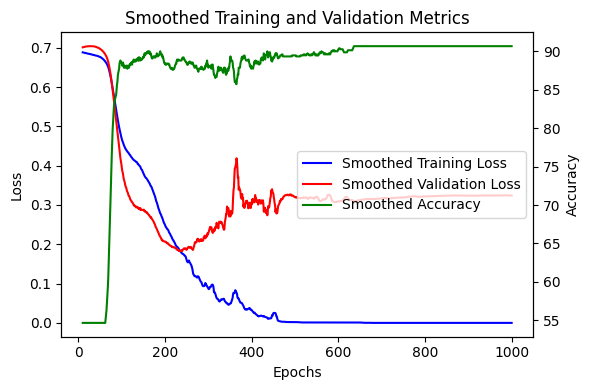

<Figure size 640x480 with 0 Axes>

In [16]:
# Define the window size for the moving average
window_size = 10  # Adjust this value to control the amount of smoothing

# Apply smoothing to the data
smooth_train_losses = moving_average(train_losses, window_size)
smooth_val_losses = moving_average(val_losses, window_size)
smooth_accuracies = moving_average(accuracies, window_size)

# Create a figure and axis objects
fig, ax1 = plt.subplots(figsize=(6, 4))

# Plot smoothed training and validation losses
epochs = range(window_size, len(train_losses) + 1)
ax1.plot(epochs, smooth_train_losses, 'b-', label='Smoothed Training Loss')
ax1.plot(epochs, smooth_val_losses, 'r-', label='Smoothed Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.tick_params(axis='y')

# Create a second y-axis for accuracy
ax2 = ax1.twinx()
ax2.plot(epochs, smooth_accuracies, 'g-', label='Smoothed Accuracy')
ax2.set_ylabel('Accuracy')
ax2.tick_params(axis='y')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right')

# Set title
plt.title('Smoothed Training and Validation Metrics')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Optionally, plot original data as faded lines for comparison
ax1.plot(range(1, len(train_losses) + 1), train_losses, 'b-', alpha=0.2)
ax1.plot(range(1, len(val_losses) + 1), val_losses, 'r-', alpha=0.2)
ax2.plot(range(1, len(accuracies) + 1), accuracies, 'g-', alpha=0.2)

plt.tight_layout()
plt.show()

### Attention Analysis

Correct example found:
Adjacency matrix shape: torch.Size([5, 5])
True label: 1.0
Model output: 0.9999885559082031
Number of attention layers: 1
Layer 1 attention shape: torch.Size([64, 25, 25])


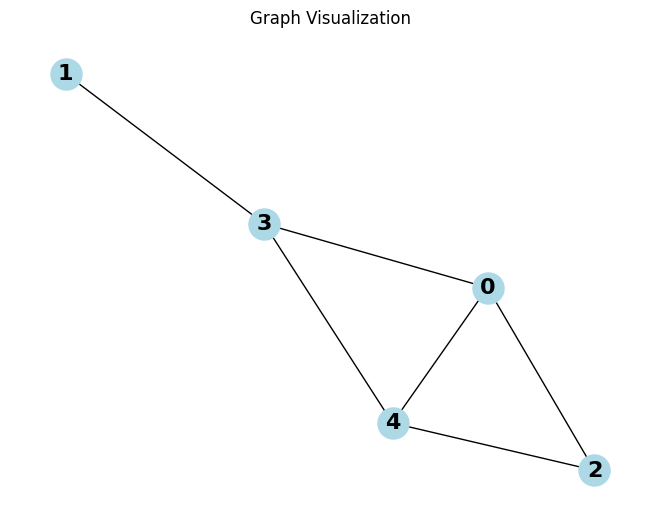

In [17]:
# Get a correct example with label 1
correct_adj, correct_label, correct_output, attention_weights = get_correct_example(model, test_loader, device, desired_label=1)

# Get a correct example with label 0
#correct_adj, correct_label, correct_output, attention_weights = get_correct_example(model, train_loader, device, desired_label=1)

if correct_adj is not None:
    print(f"Correct example found:")
    print(f"Adjacency matrix shape: {correct_adj.shape}")
    print(f"True label: {correct_label.item()}")
    print(f"Model output: {correct_output.item()}")
    print(f"Number of attention layers: {len(attention_weights)}")
    for i, layer_attention in enumerate(attention_weights):
        print(f"Layer {i+1} attention shape: {layer_attention.shape}")
else:
    print("No correctly classified examples found with the desired label in the test set.")

model.eval()
with torch.no_grad():
  correct_adj = correct_adj.to(device).unsqueeze(0)
  outputs, attention_weights = model(correct_adj)
show_graph_with_labels(correct_adj[0].detach().cpu().numpy())

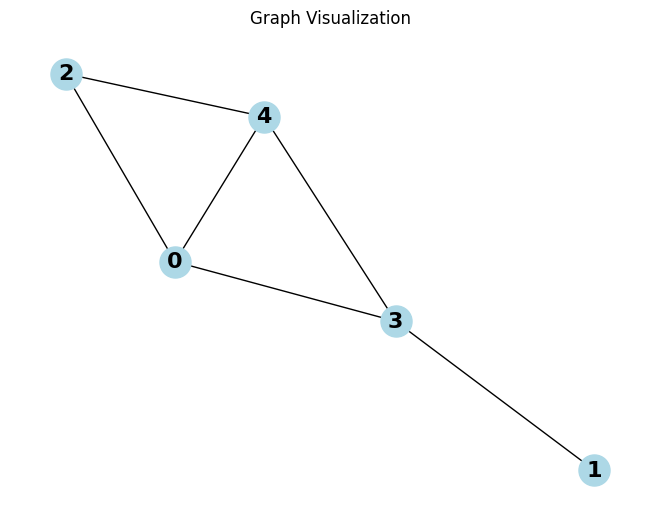

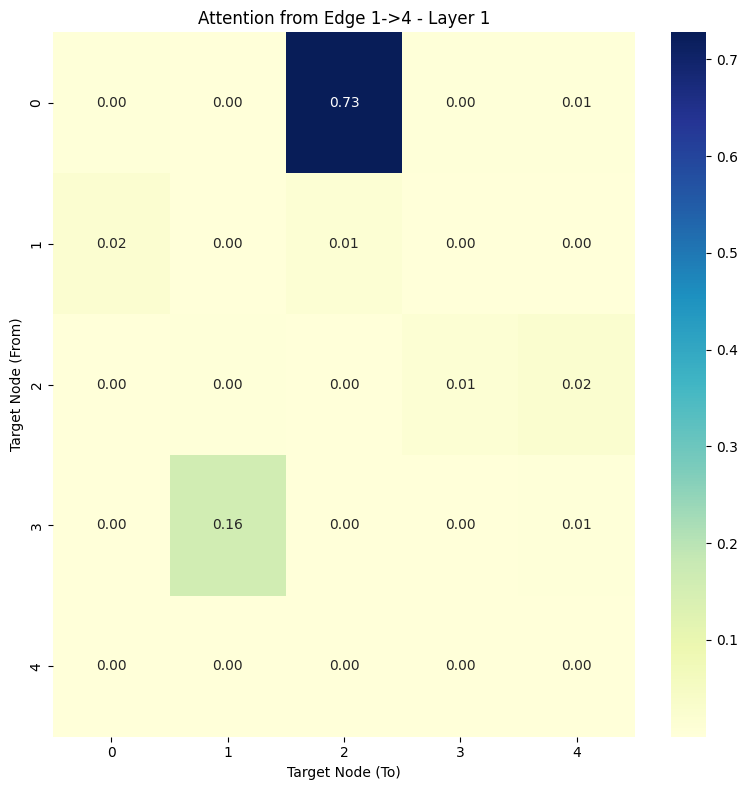

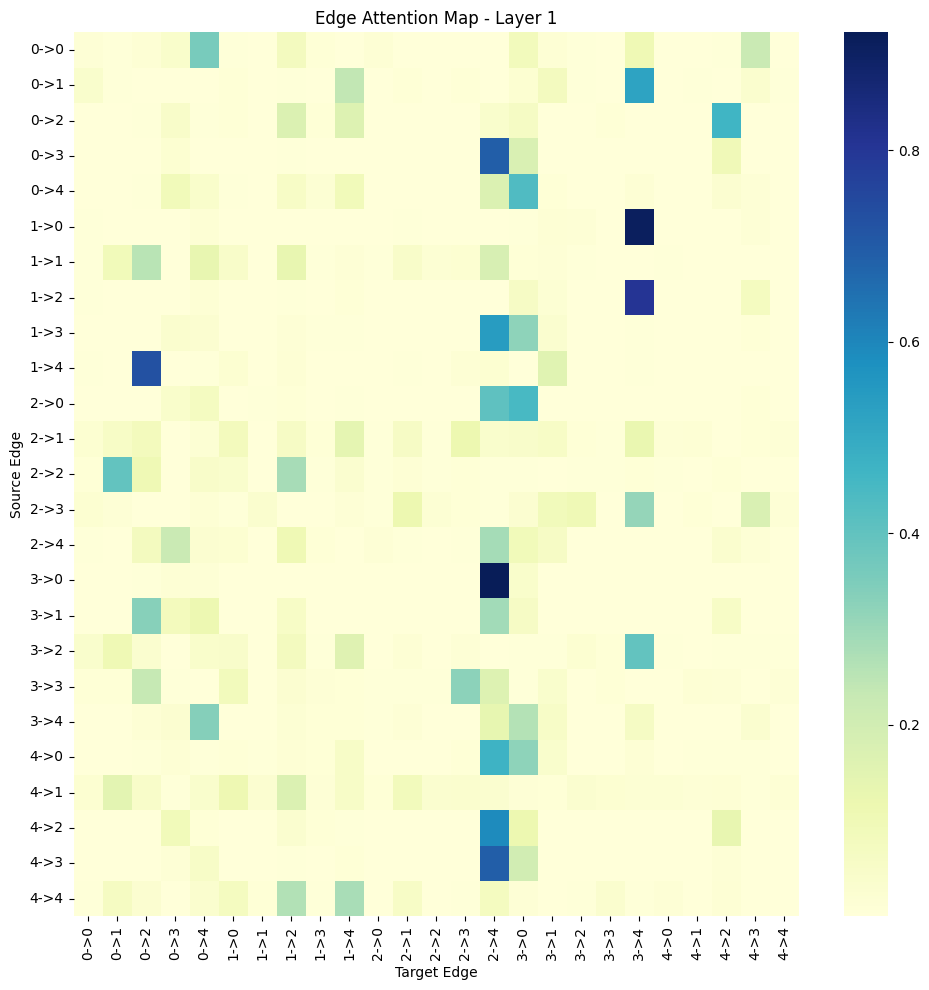

In [18]:
show_graph_with_labels(correct_adj[0].detach().cpu().numpy())
source_edge = (1,4)
visualize_single_edge_attention(attention_weights, layer_index=0, num_nodes=correct_adj[0].shape[0], source_edge=source_edge)

visualize_edge_attention(attention_weights, layer_index=0, num_nodes=correct_adj[0].shape[0], figsize=(10, 10))

### Dataset 2 -> After meeting of 25-07-24

In [46]:
adj_matrix = np.array([
    [0, 1, 1, 1, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 1, 1, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0]
])

isomorphic_graphs_single_t = generate_isomorphic_graphs(adj_matrix)

adj_matrix = np.array([
    [0, 1, 1, 1, 0, 0, 0, 0],
    [1, 0, 0, 0, 1, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 1, 1, 0, 0],
    [0, 1, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0]
])

isomorphic_graphs_non_t_cycle = generate_isomorphic_graphs(adj_matrix)

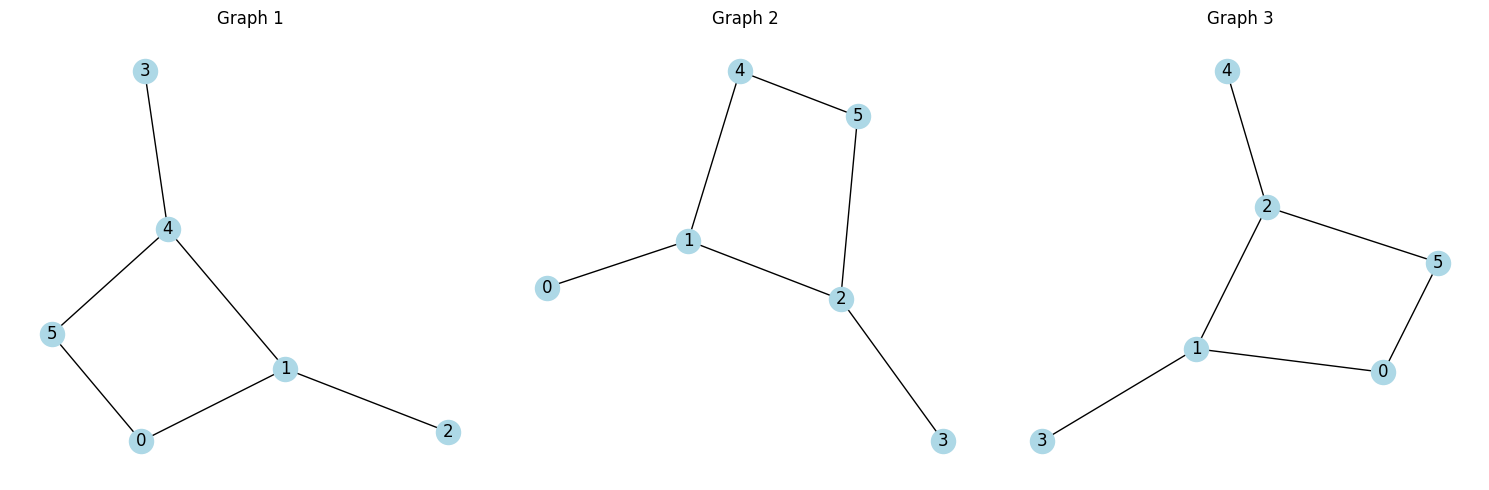

In [47]:
# Plot 3 graphs in a row
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first graph
G = nx.from_numpy_matrix(isomorphic_graphs_non_t_cycle[0])
pos = nx.spring_layout(G)
nx.draw(G, pos, ax=ax[0], with_labels=True, node_color='lightblue')
ax[0].set_title('Graph 1')

# Plot the second graph
G = nx.from_numpy_matrix(isomorphic_graphs_non_t_cycle[1])
pos = nx.spring_layout(G)
nx.draw(G, pos, ax=ax[1], with_labels=True, node_color='lightblue')
ax[1].set_title('Graph 2')

# Plot the third graph
G = nx.from_numpy_matrix(isomorphic_graphs_non_t_cycle[2])
pos = nx.spring_layout(G)
nx.draw(G, pos, ax=ax[2], with_labels=True, node_color='lightblue')
ax[2].set_title('Graph 3')

plt.tight_layout()
plt.show()



In [20]:

# Combine the adjacency matrices into a single dataset
adj_matrices = np.array(isomorphic_graphs_single_t + isomorphic_graphs_non_t_cycle)
adj_matrices.shape

# Create a list with the values of the labels
labels = [1] * len(isomorphic_graphs_single_t) + [0] * len(isomorphic_graphs_non_t_cycle)
labels = np.array(labels)
labels

ceros = []
unos = []
for a, l in zip(adj_matrices, labels):
  if l == 1:
    unos.append(a)
  else:
    ceros.append(a)

print("Unique Adj:", len(get_unique_adj_matrices(adj_matrices)))

print("Size per class:")
print(len(unos), len(ceros))

print("Edges per class")
print(np.mean([np.sum(c) for c in unos]), np.mean([np.sum(c) for c in ceros]))

adj_matrices_1 = adj_matrices[list(map(bool,labels)), :, :]
adj_matrices_0 = adj_matrices[list(map(lambda x: bool(0**x),labels)), :, :]

Unique Adj: 540
Size per class:
180 360
Edges per class
12.0 12.0


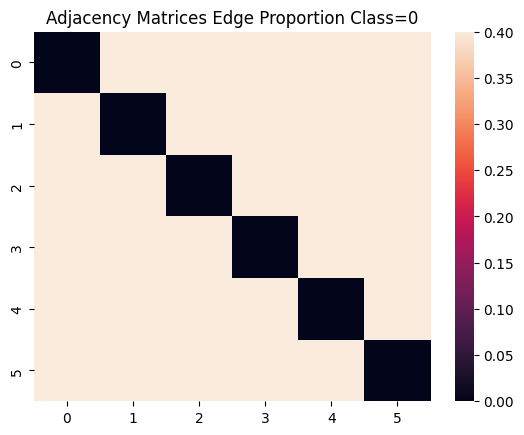

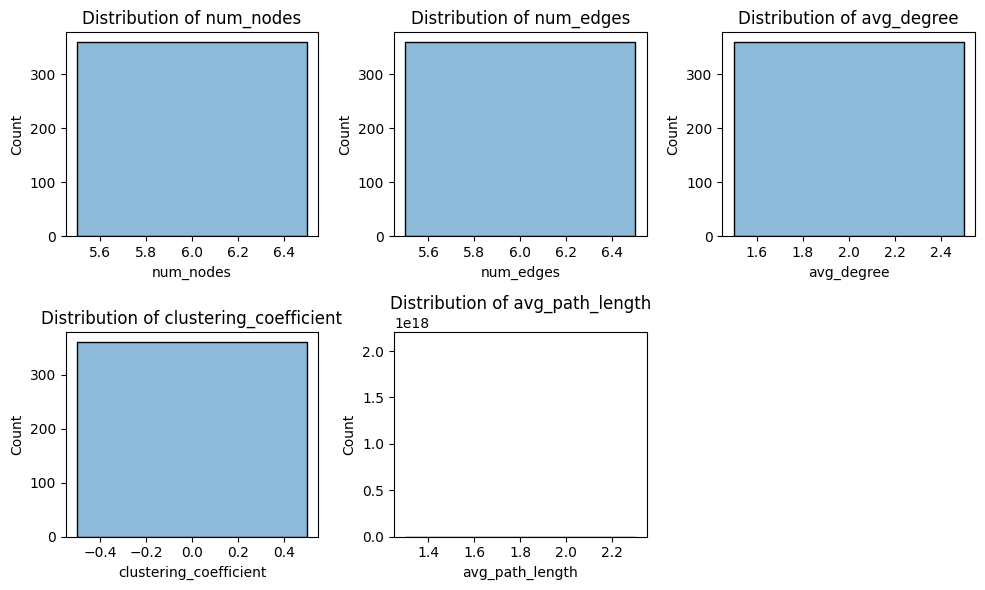

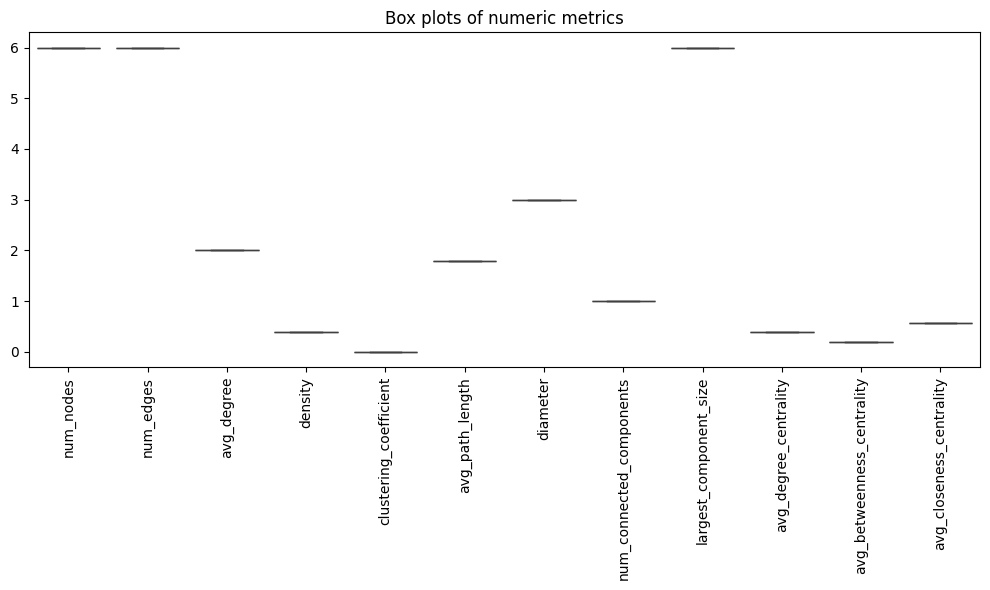

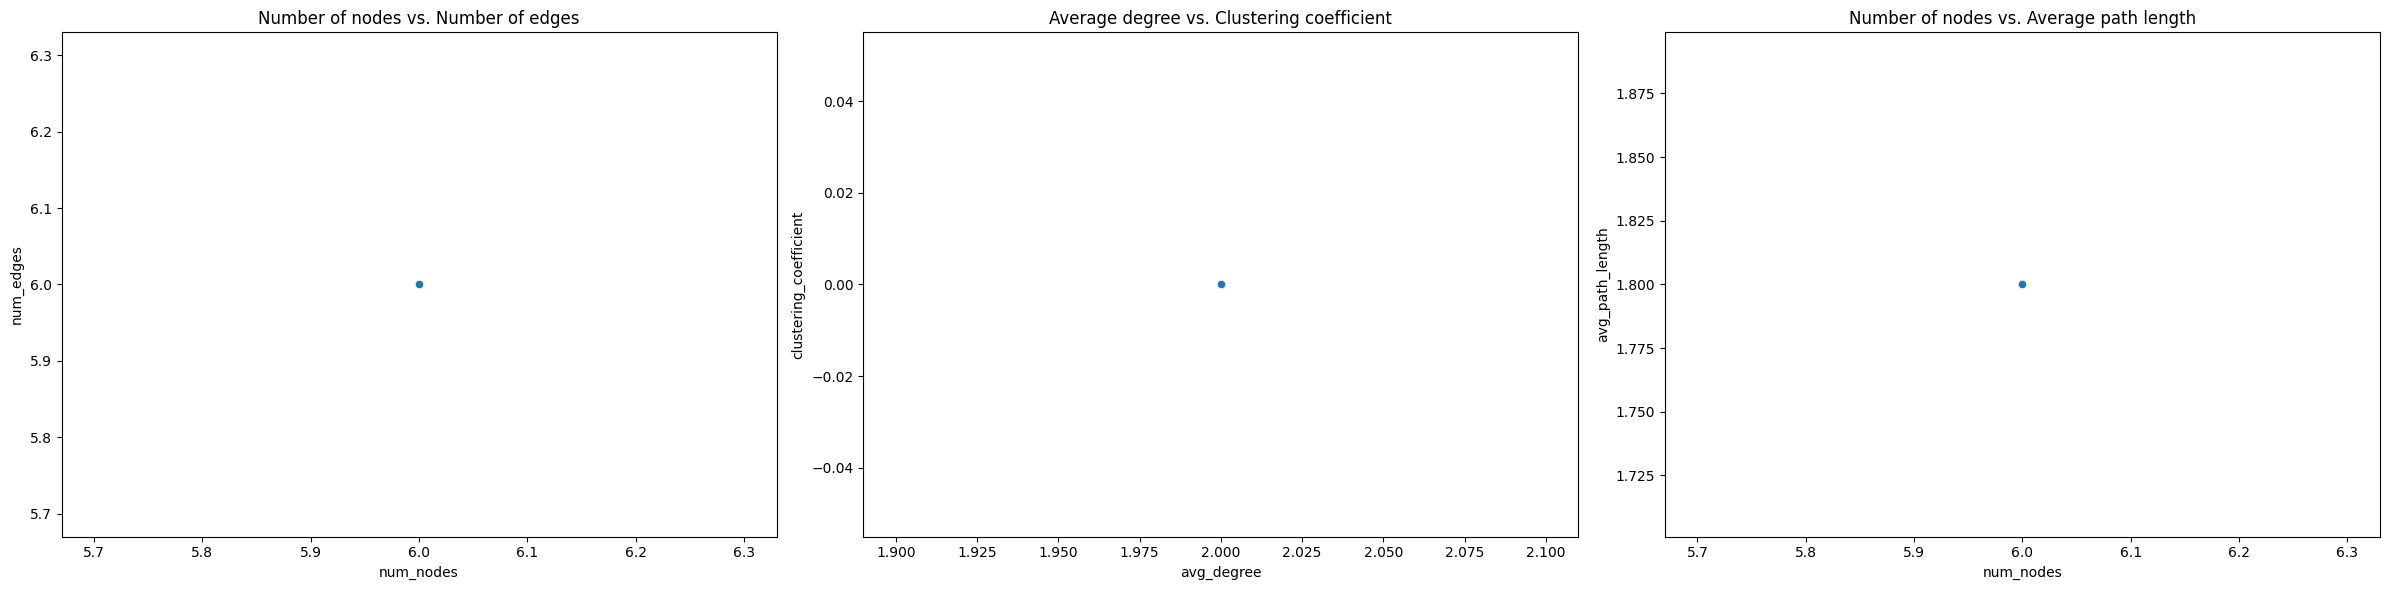

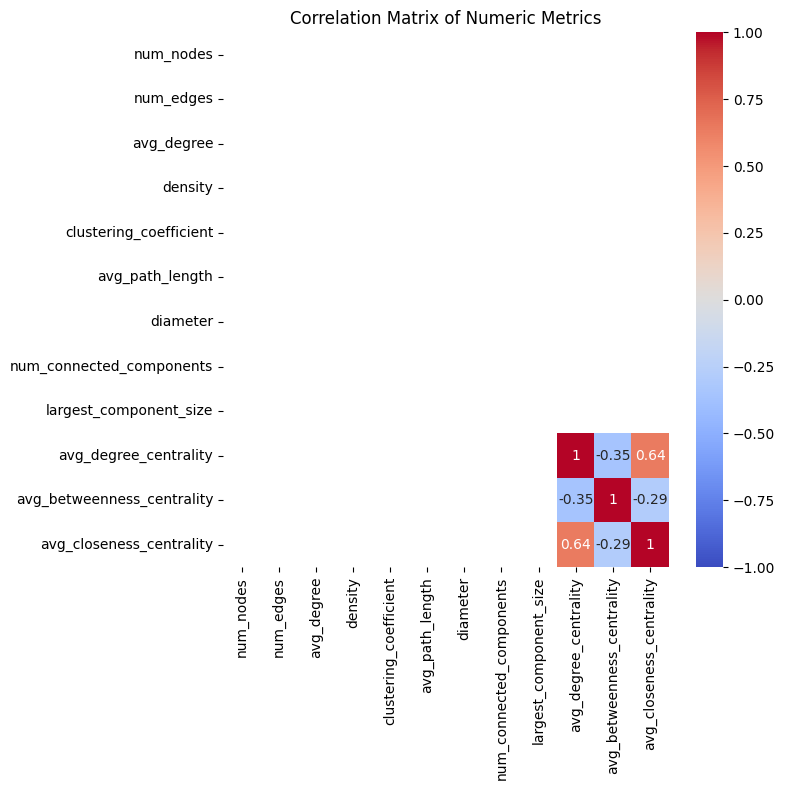

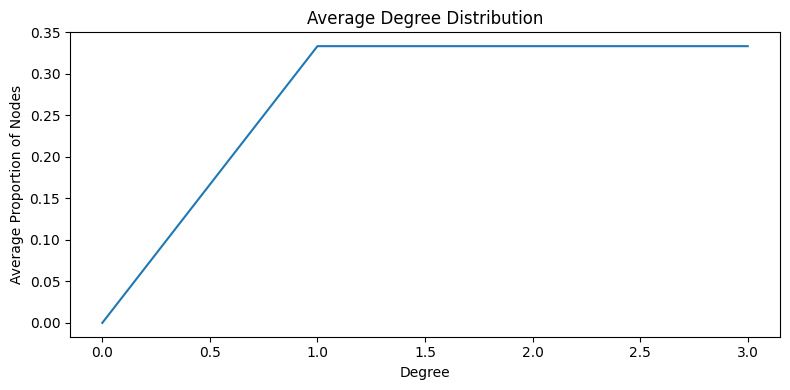

All visualizations have been displayed.


In [21]:
# Calculate metrics for each graph
individual_metrics = calculate_graph_metrics(adj_matrices_0)
# Calculate summary statistics for the dataset
dataset_summary = summarize_dataset_metrics(individual_metrics)
sns.heatmap(np.mean(adj_matrices_0, 0))
plt.title('Adjacency Matrices Edge Proportion Class=0')
# Create visualizations
create_visualizations(individual_metrics, dataset_summary)

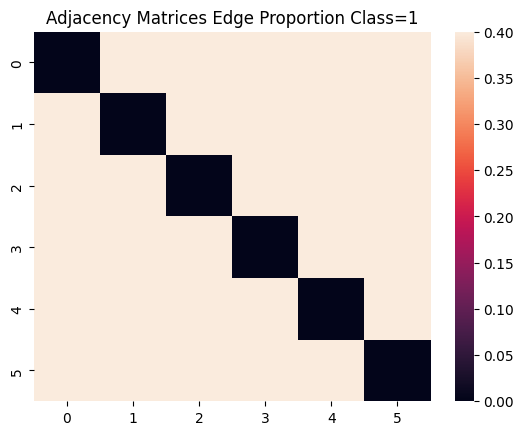

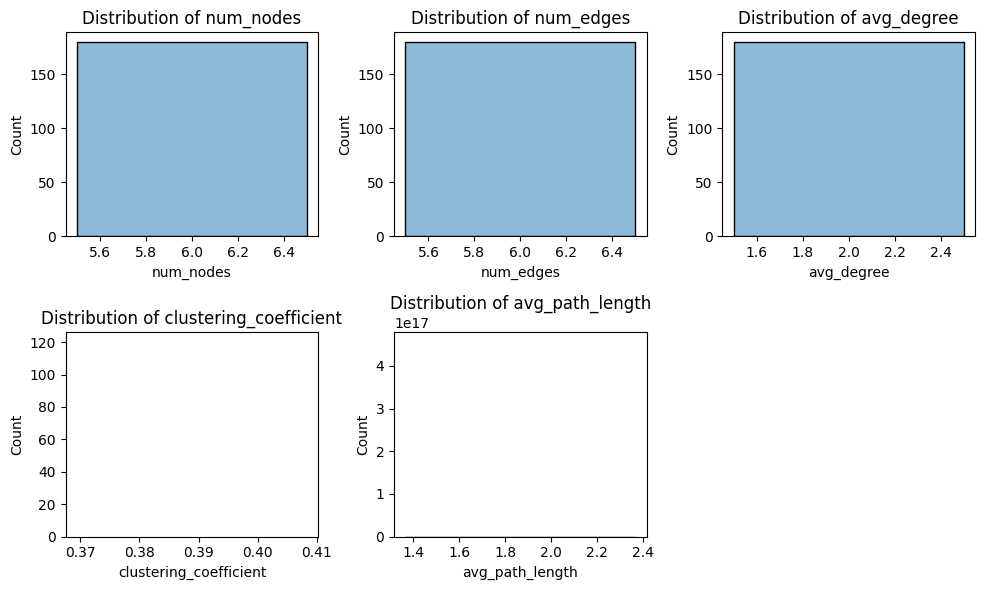

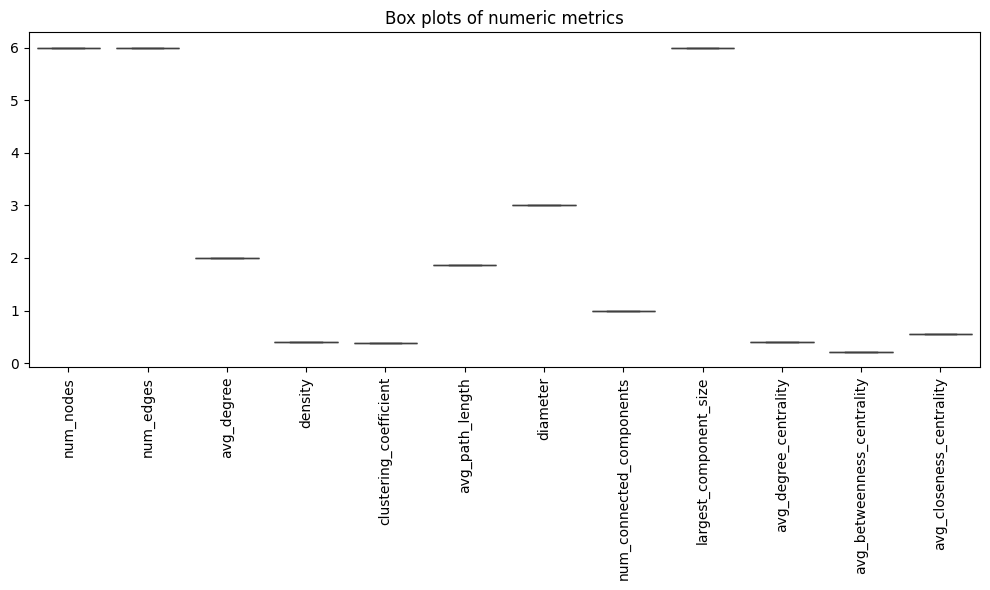

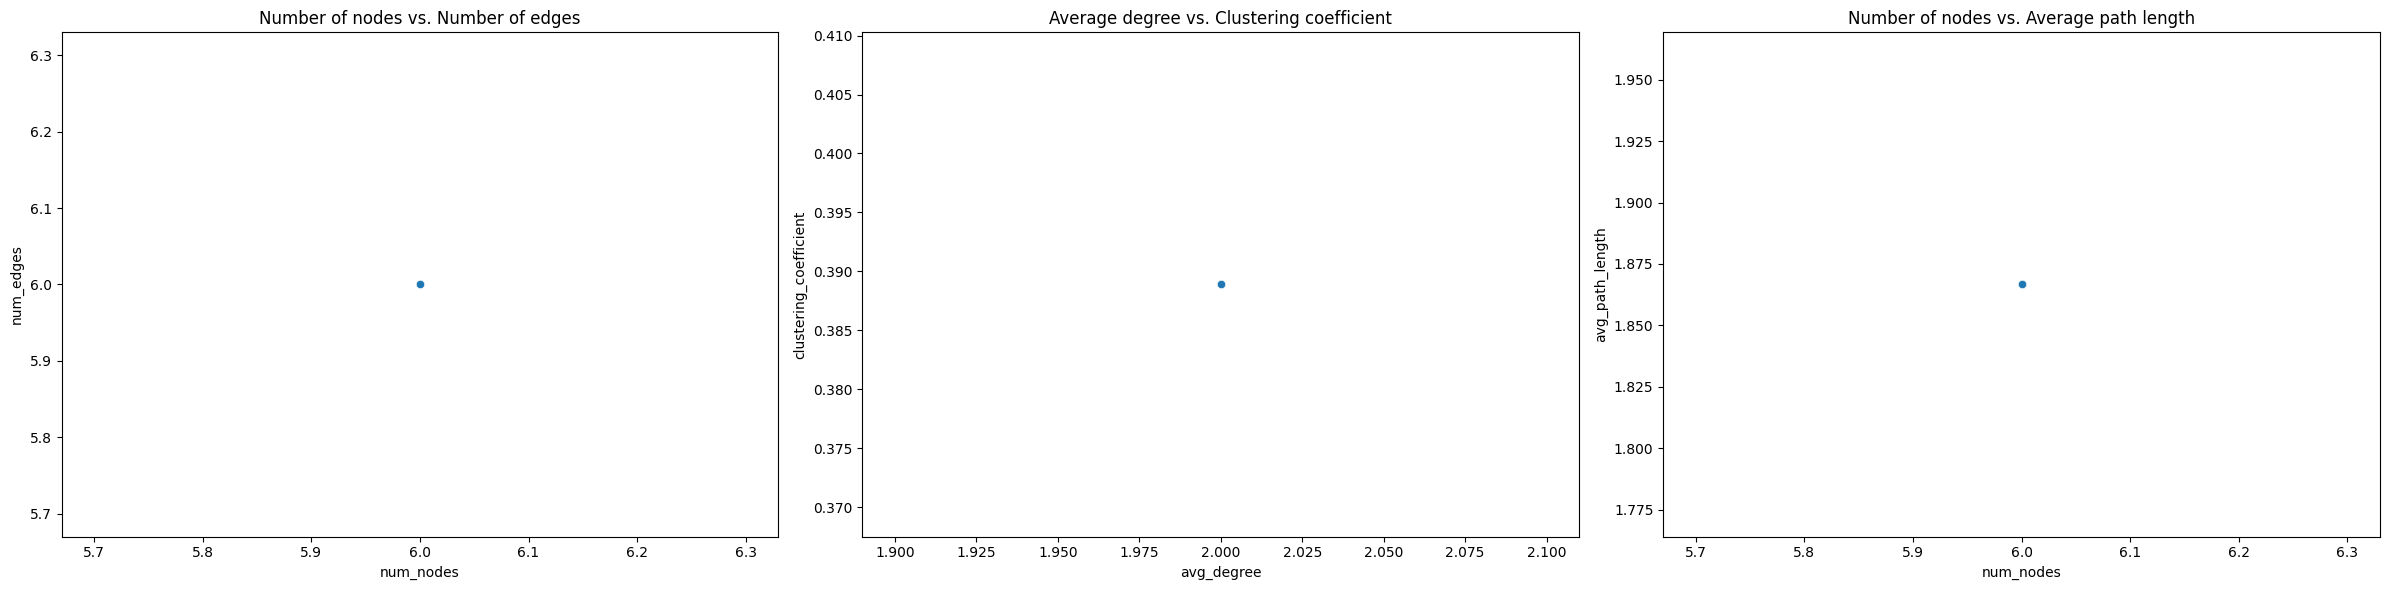

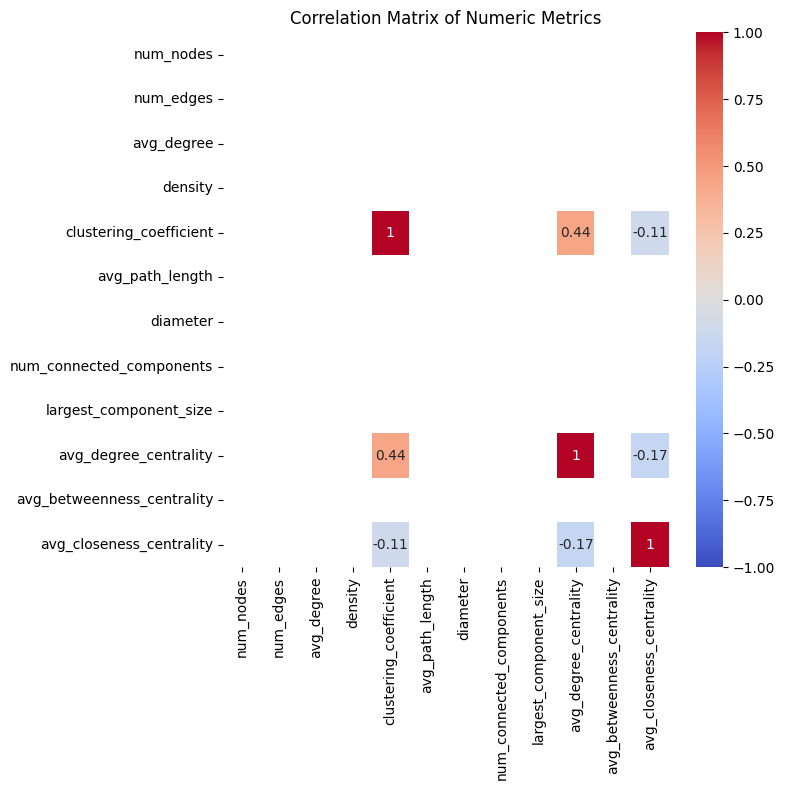

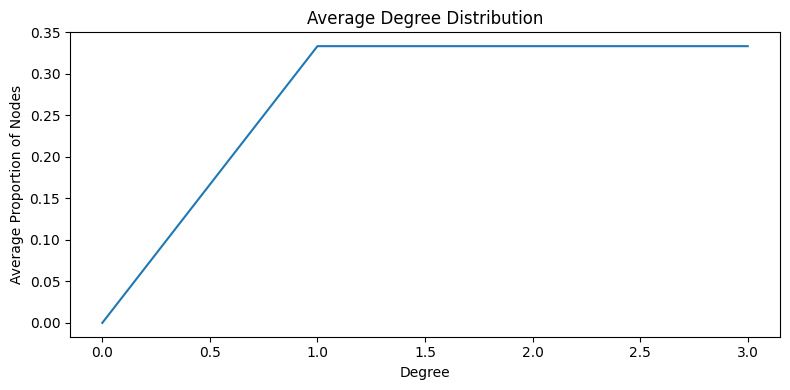

All visualizations have been displayed.


In [22]:
# Calculate metrics for each graph
individual_metrics = calculate_graph_metrics(adj_matrices_1)
# Calculate summary statistics for the dataset
dataset_summary = summarize_dataset_metrics(individual_metrics)
sns.heatmap(np.mean(adj_matrices_1, 0))
plt.title('Adjacency Matrices Edge Proportion Class=1')
# Create visualizations
create_visualizations(individual_metrics, dataset_summary)

In [23]:
class GraphDataset(Dataset):
    def __init__(self, adj_matrices, labels):
        self.adj_matrices = adj_matrices
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.adj_matrices[idx], self.labels[idx]

In [24]:
def collate_fn(batch):
    adj_matrices, labels = zip(*batch)

    # Find max number of nodes
    max_nodes = max(len(adj) for adj in adj_matrices)

    # Pad adjacency matrices
    padded_adj = []
    for adj in adj_matrices:
        pad_size = max_nodes - len(adj)
        padded = np.pad(adj, ((0, pad_size), (0, pad_size)), mode='constant')
        padded_adj.append(padded)

    # Convert to PyTorch tensors
    padded_adj = np.array(padded_adj)
    adj_tensor = torch.FloatTensor(padded_adj)

    labels_tensor = torch.FloatTensor(labels)

    return adj_tensor, labels_tensor

In [25]:
# Create dataset
dataset = GraphDataset(adj_matrices, labels)

# Create train-test split
train_size = int(0.8 * len(dataset))
print(train_size)
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

432


### MLP

Epoch 1/1000, Train Loss: 0.6683, Test Loss: 0.6439
Epoch 2/1000, Train Loss: 0.6614, Test Loss: 0.6335
Epoch 3/1000, Train Loss: 0.6575, Test Loss: 0.6261
Epoch 4/1000, Train Loss: 0.6533, Test Loss: 0.6158
Epoch 5/1000, Train Loss: 0.6494, Test Loss: 0.6061
Epoch 6/1000, Train Loss: 0.6482, Test Loss: 0.6034
Epoch 7/1000, Train Loss: 0.6471, Test Loss: 0.6105
Epoch 8/1000, Train Loss: 0.6468, Test Loss: 0.6027
Epoch 9/1000, Train Loss: 0.6433, Test Loss: 0.6132
Epoch 10/1000, Train Loss: 0.6454, Test Loss: 0.6036
Epoch 11/1000, Train Loss: 0.6438, Test Loss: 0.6127
Epoch 12/1000, Train Loss: 0.6444, Test Loss: 0.6165
Epoch 13/1000, Train Loss: 0.6423, Test Loss: 0.6119
Epoch 00014: reducing learning rate of group 0 to 1.0000e-04.
Epoch 14/1000, Train Loss: 0.6436, Test Loss: 0.6118
Epoch 15/1000, Train Loss: 0.6407, Test Loss: 0.6135
Epoch 16/1000, Train Loss: 0.6437, Test Loss: 0.6124
Epoch 17/1000, Train Loss: 0.6416, Test Loss: 0.6049
Epoch 18/1000, Train Loss: 0.6439, Test Loss: 

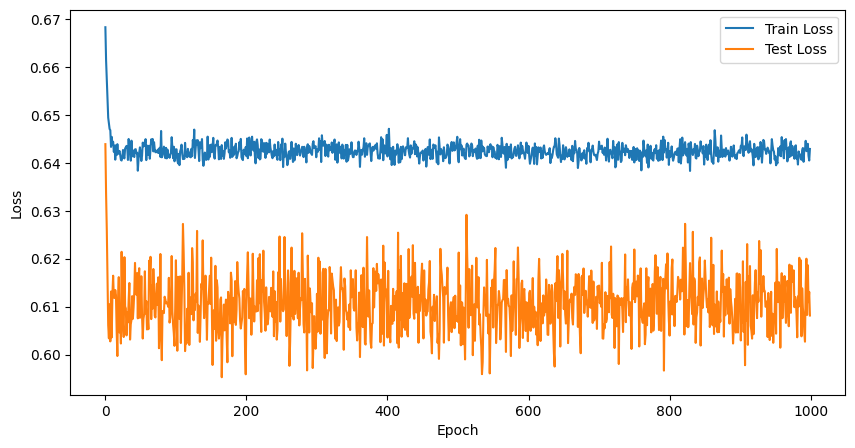

Accuracy: 0.73


In [26]:
# Generate an MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x
    
# Initialize the model
input_size = adj_matrices.shape[1] * adj_matrices.shape[2]
hidden_size = 16
output_size = 1

model = MLP(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Train the model
num_epochs = 1000
train_losses = []
test_losses = []
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for adj, labels in train_loader:
        adj = adj.view(-1, input_size)
        optimizer.zero_grad()
        outputs = model(adj)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for adj, labels in test_loader:
            adj = adj.view(-1, input_size)
            outputs = model(adj)
            loss = criterion(outputs.squeeze(), labels)
            test_loss += loss.item()
        test_loss /= len(test_loader)
        test_losses.append(test_loss)

    scheduler.step(test_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

# Plot the training and test losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')

plt.ylabel('Loss')
plt.legend()
plt.show()


#TODO: accuracy plots

# Show accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for adj, labels in test_loader:
        adj = adj.view(-1, input_size)
        outputs = model(adj)
        predicted = torch.round(torch.sigmoid(outputs))
        total += labels.size(0)
        correct += (predicted.squeeze() == labels).sum().item()

print(f'Accuracy: {correct / total:.2f}')


Precision: 0.00, Recall: 0.00, F1: 0.00, AUC: 0.50


/Users/franciscomeza/.pyenv/versions/3.8.18/envs/mining-project/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


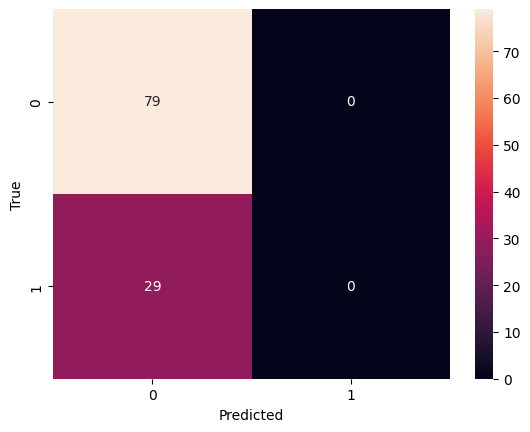

              precision    recall  f1-score   support

         0.0       0.73      1.00      0.84        79
         1.0       0.00      0.00      0.00        29

    accuracy                           0.73       108
   macro avg       0.37      0.50      0.42       108
weighted avg       0.54      0.73      0.62       108



/Users/franciscomeza/.pyenv/versions/3.8.18/envs/mining-project/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/franciscomeza/.pyenv/versions/3.8.18/envs/mining-project/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/franciscomeza/.pyenv/versions/3.8.18/envs/mining-project/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

In [27]:
# Show metrics as Precision, Recall, F1, AUC
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for adj, labels in test_loader:
        adj = adj.view(-1, input_size)
        outputs = model(adj)
        predicted = torch.round(torch.sigmoid(outputs))
        y_true += labels.tolist()
        y_pred += predicted.squeeze().tolist()

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
auc = roc_auc_score(y_true, y_pred)

print(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}, AUC: {auc:.2f}')

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
print(classification_report(y_true, y_pred))


### Transformer

Train Size: 432
Epoch 1/1000, Train Loss: 0.6482, Val Loss: 0.6445, Accuracy: 66.67%
Epoch 11/1000, Train Loss: 0.6355, Val Loss: 0.6353, Accuracy: 66.67%
Epoch 21/1000, Train Loss: 0.6365, Val Loss: 0.6422, Accuracy: 66.67%
Epoch 31/1000, Train Loss: 0.6355, Val Loss: 0.6323, Accuracy: 66.67%
Epoch 41/1000, Train Loss: 0.6350, Val Loss: 0.6299, Accuracy: 66.67%
Epoch 51/1000, Train Loss: 0.6355, Val Loss: 0.6348, Accuracy: 66.67%
Epoch 61/1000, Train Loss: 0.6387, Val Loss: 0.6422, Accuracy: 66.67%
Epoch 71/1000, Train Loss: 0.6354, Val Loss: 0.6276, Accuracy: 66.67%
Epoch 81/1000, Train Loss: 0.6383, Val Loss: 0.6349, Accuracy: 66.67%
Epoch 91/1000, Train Loss: 0.6374, Val Loss: 0.6349, Accuracy: 66.67%
Epoch 101/1000, Train Loss: 0.6402, Val Loss: 0.6374, Accuracy: 66.67%
Epoch 111/1000, Train Loss: 0.6346, Val Loss: 0.6375, Accuracy: 66.67%
Epoch 121/1000, Train Loss: 0.6388, Val Loss: 0.6350, Accuracy: 66.67%
Epoch 131/1000, Train Loss: 0.6356, Val Loss: 0.6400, Accuracy: 66.67%
E

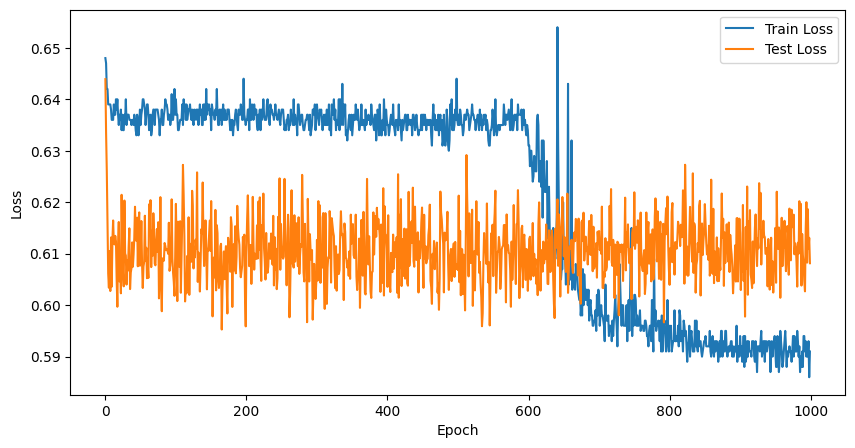

Test Loss: 0.6495, Accuracy: 68.52%


In [28]:
# Create train-test split
train_size = int(0.8 * len(dataset))
print("Train Size:", train_size)
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

# Initialize model, loss function, and optimizer
max_nodes = 8
hidden_dim = 32
num_heads = 1
num_layers = 1
lr = 1e-3
num_epochs = 1000

# 2D positional encoding
model = GraphTransformerClassifier(max_nodes, hidden_dim, num_heads, num_layers, True)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, epochs=num_epochs, steps_per_epoch=len(train_loader))


# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

accuracies = []
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for adj, labels in train_loader:
        adj, labels = adj.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, attention_w = model(adj)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for adj, labels in test_loader:
            adj, labels = adj.to(device), labels.to(device)
            outputs, attention_w = model(adj)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    if epoch%10 == 0:
      print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, '
            f'Val Loss: {val_loss/len(test_loader):.4f}, Accuracy: {100*correct/total:.2f}%')
    train_losses.append(round(train_loss/len(train_loader), 3))
    val_losses.append(round(val_loss/len(test_loader), 3))
    accuracies.append(round(100*correct/total, 3))

# Final test
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for adj, labels in test_loader:
        adj, labels = adj.to(device), labels.to(device)
        outputs, attention_w = model(adj)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Plot the training and test losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')

plt.ylabel('Loss')
plt.legend()
plt.show()

print(f'Test Loss: {test_loss/len(test_loader):.4f}, Accuracy: {100*correct/total:.2f}%')

Precision: 1.00, Recall: 0.06, F1: 0.11, AUC: 0.53


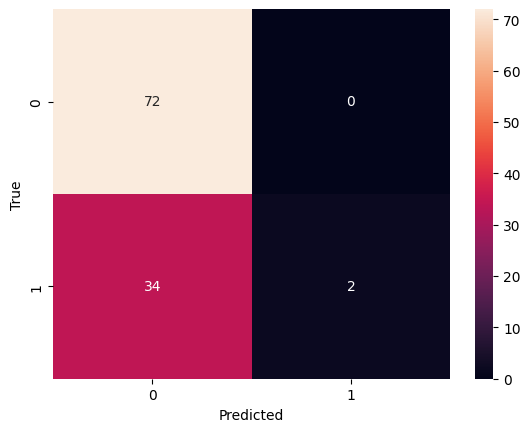

              precision    recall  f1-score   support

         0.0       0.68      1.00      0.81        72
         1.0       1.00      0.06      0.11        36

    accuracy                           0.69       108
   macro avg       0.84      0.53      0.46       108
weighted avg       0.79      0.69      0.57       108



In [29]:
# Show metrics as Precision, Recall, F1, AUC
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for adj, labels in test_loader:
        adj, labels = adj.to(device), labels.to(device)
        outputs, attention_w = model(adj)
        predicted = (outputs > 0.5).float()
        y_true += labels.tolist()
        y_pred += predicted.squeeze().tolist()

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
auc = roc_auc_score(y_true, y_pred)

print(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}, AUC: {auc:.2f}')

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
print(classification_report(y_true, y_pred))


Epoch 1/1000, Train Loss: 0.7755, Val Loss: 0.7682, Accuracy: 33.33%
Epoch 11/1000, Train Loss: 0.7080, Val Loss: 0.7058, Accuracy: 33.33%
Epoch 21/1000, Train Loss: 0.6642, Val Loss: 0.6644, Accuracy: 66.67%
Epoch 31/1000, Train Loss: 0.6439, Val Loss: 0.6436, Accuracy: 66.67%
Epoch 41/1000, Train Loss: 0.6372, Val Loss: 0.6405, Accuracy: 66.67%
Epoch 51/1000, Train Loss: 0.6350, Val Loss: 0.6398, Accuracy: 66.67%
Epoch 61/1000, Train Loss: 0.6350, Val Loss: 0.6300, Accuracy: 66.67%
Epoch 71/1000, Train Loss: 0.6386, Val Loss: 0.6449, Accuracy: 66.67%
Epoch 81/1000, Train Loss: 0.6376, Val Loss: 0.6499, Accuracy: 66.67%
Epoch 91/1000, Train Loss: 0.6345, Val Loss: 0.6424, Accuracy: 66.67%
Epoch 101/1000, Train Loss: 0.6366, Val Loss: 0.6399, Accuracy: 66.67%
Epoch 111/1000, Train Loss: 0.6365, Val Loss: 0.6399, Accuracy: 66.67%
Epoch 121/1000, Train Loss: 0.6366, Val Loss: 0.6475, Accuracy: 66.67%
Epoch 131/1000, Train Loss: 0.6355, Val Loss: 0.6399, Accuracy: 66.67%
Epoch 141/1000, T

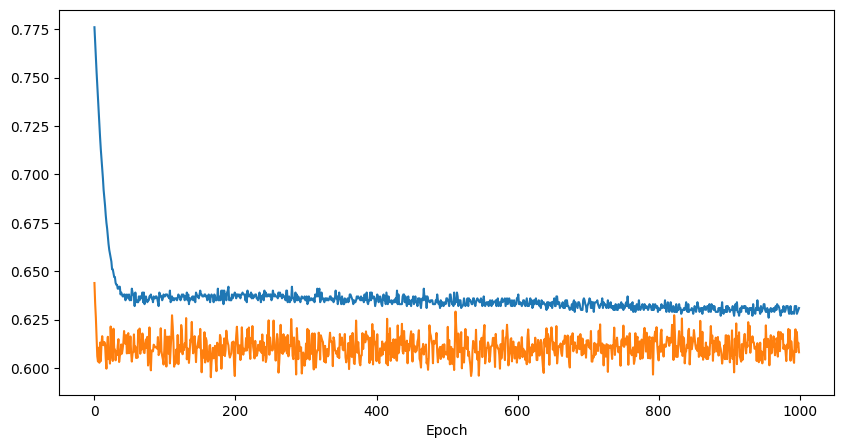

In [30]:
# 1D positional encoding
model = GraphTransformerClassifier(max_nodes, hidden_dim, num_heads, num_layers, False)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, epochs=num_epochs, steps_per_epoch=len(train_loader))


# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

accuracies = []
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for adj, labels in train_loader:
        adj, labels = adj.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, attention_w = model(adj)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for adj, labels in test_loader:
            adj, labels = adj.to(device), labels.to(device)
            outputs, attention_w = model(adj)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    if epoch%10 == 0:
      print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, '
            f'Val Loss: {val_loss/len(test_loader):.4f}, Accuracy: {100*correct/total:.2f}%')
    train_losses.append(round(train_loss/len(train_loader), 3))
    val_losses.append(round(val_loss/len(test_loader), 3))
    accuracies.append(round(100*correct/total, 3))

# Final test
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for adj, labels in test_loader:
        adj, labels = adj.to(device), labels.to(device)
        outputs, attention_w = model(adj)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Plot the training and test losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')

print(f'Test Loss: {test_loss/len(test_loader):.4f}, Accuracy: {100*correct/total:.2f}%')

Precision: 0.00, Recall: 0.00, F1: 0.00, AUC: 0.50


/Users/franciscomeza/.pyenv/versions/3.8.18/envs/mining-project/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


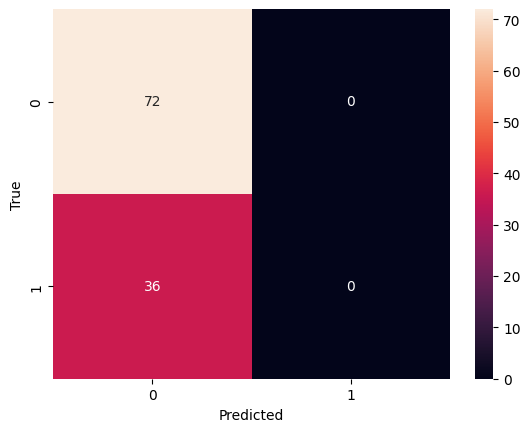

              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80        72
         1.0       0.00      0.00      0.00        36

    accuracy                           0.67       108
   macro avg       0.33      0.50      0.40       108
weighted avg       0.44      0.67      0.53       108



/Users/franciscomeza/.pyenv/versions/3.8.18/envs/mining-project/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/franciscomeza/.pyenv/versions/3.8.18/envs/mining-project/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/franciscomeza/.pyenv/versions/3.8.18/envs/mining-project/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

In [31]:
# Show metrics as Precision, Recall, F1, AUC
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for adj, labels in test_loader:
        adj, labels = adj.to(device), labels.to(device)
        outputs, attention_w = model(adj)
        predicted = (outputs > 0.5).float()
        y_true += labels.tolist()
        y_pred += predicted.squeeze().tolist()

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
auc = roc_auc_score(y_true, y_pred)

print(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}, AUC: {auc:.2f}')

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
print(classification_report(y_true, y_pred))

Epoch 1/1000, Train Loss: 0.7014, Val Loss: 0.6996, Accuracy: 33.33%
Epoch 11/1000, Train Loss: 0.6784, Val Loss: 0.6788, Accuracy: 66.67%
Epoch 21/1000, Train Loss: 0.6564, Val Loss: 0.6570, Accuracy: 66.67%
Epoch 31/1000, Train Loss: 0.6429, Val Loss: 0.6414, Accuracy: 66.67%
Epoch 41/1000, Train Loss: 0.6343, Val Loss: 0.6295, Accuracy: 66.67%
Epoch 51/1000, Train Loss: 0.6365, Val Loss: 0.6277, Accuracy: 66.67%
Epoch 61/1000, Train Loss: 0.6386, Val Loss: 0.6350, Accuracy: 66.67%
Epoch 71/1000, Train Loss: 0.6355, Val Loss: 0.6375, Accuracy: 66.67%
Epoch 81/1000, Train Loss: 0.6360, Val Loss: 0.6351, Accuracy: 66.67%
Epoch 91/1000, Train Loss: 0.6380, Val Loss: 0.6302, Accuracy: 66.67%
Epoch 101/1000, Train Loss: 0.6351, Val Loss: 0.6305, Accuracy: 66.67%
Epoch 111/1000, Train Loss: 0.6380, Val Loss: 0.6277, Accuracy: 66.67%
Epoch 121/1000, Train Loss: 0.6385, Val Loss: 0.6378, Accuracy: 66.67%
Epoch 131/1000, Train Loss: 0.6342, Val Loss: 0.6257, Accuracy: 66.67%
Epoch 141/1000, T

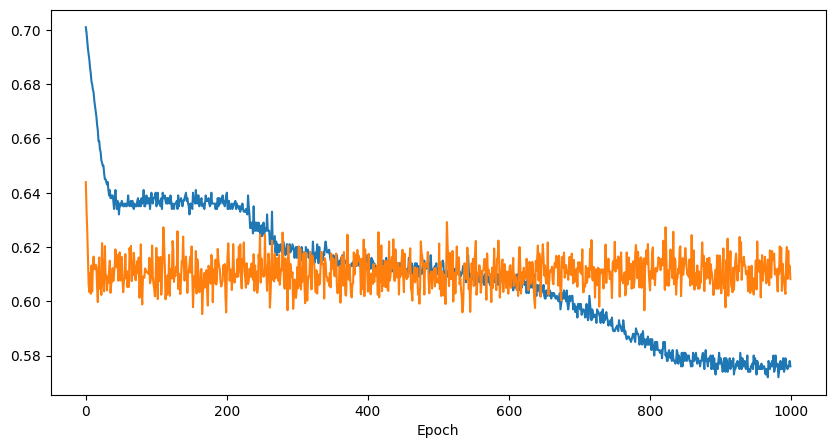

In [32]:
# Embedding Table
model = GraphTransformerClassifierET(max_nodes, hidden_dim, num_heads, num_layers)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, epochs=num_epochs, steps_per_epoch=len(train_loader))


# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

accuracies = []
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for adj, labels in train_loader:
        adj, labels = adj.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, attention_w = model(adj)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for adj, labels in test_loader:
            adj, labels = adj.to(device), labels.to(device)
            outputs, attention_w = model(adj)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    if epoch%10 == 0:
      print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, '
            f'Val Loss: {val_loss/len(test_loader):.4f}, Accuracy: {100*correct/total:.2f}%')
    train_losses.append(round(train_loss/len(train_loader), 3))
    val_losses.append(round(val_loss/len(test_loader), 3))
    accuracies.append(round(100*correct/total, 3))

# Final test
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for adj, labels in test_loader:
        adj, labels = adj.to(device), labels.to(device)
        outputs, attention_w = model(adj)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Plot the training and test losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')

print(f'Test Loss: {test_loss/len(test_loader):.4f}, Accuracy: {100*correct/total:.2f}%')

In [33]:
# Show metrics as Precision, Recall, F1, AUC
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for adj, labels in test_loader:
        adj, labels = adj.to(device), labels.to(device)
        outputs, attention_w = model(adj)
        predicted = (outputs > 0.5).float()
        y_true += labels.tolist()
        y_pred += predicted.squeeze().tolist()

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
auc = roc_auc_score(y_true, y_pred)

print(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}, AUC: {auc:.2f}')

# Classification report
print(classification_report(y_true, y_pred))

Precision: 0.22, Recall: 0.06, F1: 0.09, AUC: 0.48
              precision    recall  f1-score   support

         0.0       0.66      0.90      0.76        72
         1.0       0.22      0.06      0.09        36

    accuracy                           0.62       108
   macro avg       0.44      0.48      0.42       108
weighted avg       0.51      0.62      0.54       108



### Triangle Edge Detection

In [34]:
def find_triangles(adj_matrices):
  edge_labels = []
  num_nodes = adj_matrices[0].shape[0]
  for adj in adj_matrices:
    triangle_edges = np.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            if adj[i, j] == 1:
                for k in range(j+1, num_nodes):
                    if adj[i, k] == 1 and adj[j, k] == 1:
                        triangle_edges[i, j] = triangle_edges[j, i] = 1
                        triangle_edges[i, k] = triangle_edges[k, i] = 1
                        triangle_edges[j, k] = triangle_edges[k, j] = 1
    edge_labels.append(torch.tensor(triangle_edges, dtype=torch.float32))
  return edge_labels

In [35]:
class GraphTransformerTriangleEdgeDetector(nn.Module):
    def __init__(self, max_nodes, hidden_dim, num_heads, num_layers):
        super(GraphTransformerTriangleEdgeDetector, self).__init__()
        self.max_nodes = max_nodes
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.num_layers = num_layers

        # 2D positional encoding
        self.pos_encoding = Summer(PositionalEncoding2D(hidden_dim))

        # Initial transformation of adjacency matrix
        self.input_proj = nn.Linear(1, hidden_dim)

        # Graph Transformer layers
        self.layers = nn.ModuleList([
            GraphTransformerLayer(hidden_dim, num_heads)
            for _ in range(num_layers)
        ])

        # Edge classifier
        self.edge_classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )

    def forward(self, adj_matrix):
        # adj_matrix: [batch_size, num_nodes, num_nodes]
        batch_size, num_nodes, _ = adj_matrix.size()

        # Pad adjacency matrix if necessary
        if num_nodes < self.max_nodes:
            padding = torch.zeros(batch_size, self.max_nodes - num_nodes, num_nodes, device=adj_matrix.device)
            adj_matrix = torch.cat([adj_matrix, padding], dim=1)
            padding = torch.zeros(batch_size, self.max_nodes, self.max_nodes - num_nodes, device=adj_matrix.device)
            adj_matrix = torch.cat([adj_matrix, padding], dim=2)

        # Initial projection of adjacency matrix
        x = self.input_proj(adj_matrix.unsqueeze(-1))  # [batch_size, max_nodes, max_nodes, hidden_dim]

        # Add positional encoding
        x = self.pos_encoding(x)

        # Reshape for transformer layers
        x = x.view(batch_size, self.max_nodes * self.max_nodes, self.hidden_dim)

        # Create attention mask
        attention_mask = adj_matrix.view(batch_size, self.max_nodes * self.max_nodes)
        attention_mask = attention_mask.unsqueeze(1).repeat(1, self.max_nodes * self.max_nodes, 1)
        attention_mask = (attention_mask == 0).float()
        attention_mask = attention_mask.repeat(self.num_heads, 1, 1)

        # Apply Graph Transformer layers
        for layer in self.layers:
            x, attn_weights = layer(x, attention_mask)
            attention_weights.append(attn_weights)

        # Reshape back to [batch_size, max_nodes, max_nodes, hidden_dim]
        x = x.view(batch_size, self.max_nodes, self.max_nodes, self.hidden_dim)

        # Apply edge classifier
        edge_probs = self.edge_classifier(x).squeeze(-1)

        # Make the output symmetric and zero out the diagonal
        edge_probs = (edge_probs + edge_probs.transpose(1, 2)) / 2
        edge_probs = edge_probs * (1 - torch.eye(self.max_nodes, device=edge_probs.device))

        return edge_probs

# The GraphTransformerLayer remains the same as in the original code

# Example usage
max_nodes = 5
hidden_dim = 32  # Increased for better representation
num_heads = 4
num_layers = 3
model = GraphTransformerTriangleEdgeDetector(max_nodes, hidden_dim, num_heads, num_layers)

# Create a sample adjacency matrix (batch_size=1, num_nodes=5)
adj_matrix = torch.tensor([[[0, 1, 1, 0, 0],
                            [1, 0, 1, 0, 0],
                            [1, 1, 0, 0, 0],
                            [0, 0, 0, 0, 1],
                            [0, 0, 0, 1, 0]]], dtype=torch.float32)

output = model(adj_matrix)
print(f"Output shape: {output.shape}")
print(f"Output probabilities:\n{output[0]}")

Output shape: torch.Size([1, 5, 5])
Output probabilities:
tensor([[0.0000, 0.5106, 0.5071, 0.4795, 0.4735],
        [0.5106, 0.0000, 0.5188, 0.4821, 0.4736],
        [0.5071, 0.5188, 0.0000, 0.4705, 0.4625],
        [0.4795, 0.4821, 0.4705, 0.0000, 0.4703],
        [0.4735, 0.4736, 0.4625, 0.4703, 0.0000]], grad_fn=<SelectBackward0>)


In [36]:
train_dataset = GraphDataset(list(map(lambda x: torch.tensor(x, dtype=torch.float32), isomorphic_graphs_single_t)), find_triangles(isomorphic_graphs_single_t))
test_dataset  = GraphDataset(list(map(lambda x: torch.tensor(x, dtype=torch.float32), isomorphic_graphs_double_t)), find_triangles(isomorphic_graphs_double_t))

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


# Initialize model, loss function, and optimizer
max_nodes = 6  # Assuming all matrices have the same size
hidden_dim = 32
num_heads = 1
num_layers = 1
lr = 1e-3
num_epochs = 8000

model = GraphTransformerTriangleEdgeDetector(max_nodes, hidden_dim, num_heads, num_layers)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, epochs=num_epochs, steps_per_epoch=len(train_loader))

# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

accuracies = []
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for adj, edge_labels in train_loader:
        adj, edge_labels = adj.to(device), edge_labels.to(device)

        optimizer.zero_grad()
        outputs = model(adj)

        # Apply mask to only consider existing edges
        # mask = adj != 0
        # loss = criterion(outputs[mask], edge_labels[mask])
        loss = criterion(outputs, edge_labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for adj, edge_labels in test_loader:
            adj, edge_labels = adj.to(device), edge_labels.to(device)
            outputs = model(adj)

            # # Apply mask to only consider existing edges
            # mask = adj != 0
            # loss = criterion(outputs[mask], edge_labels[mask])
            # val_loss += loss.item()

            # predicted = (outputs > 0.5).float()
            # total += mask.sum().item()
            # correct += ((predicted == edge_labels) & mask).sum().item()

            # Calculate loss on all edges
            loss = criterion(outputs, edge_labels)
            val_loss += loss.item()

            predicted = (outputs > 0.5).float()
            total += edge_labels.numel()
            correct += (predicted == edge_labels).sum().item()

    if (epoch+1)%10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, '
              f'Val Loss: {val_loss/len(test_loader):.4f}, Accuracy: {100*correct/total:.2f}%')
    train_losses.append(round(train_loss/len(train_loader), 3))
    val_losses.append(round(val_loss/len(test_loader), 3))
    accuracies.append(round(100*correct/total, 3))

# Final test
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for adj, edge_labels in test_loader:
        adj, edge_labels = adj.to(device), edge_labels.to(device)
        outputs = model(adj)

        # Apply mask to only consider existing edges
        # mask = adj != 0
        # loss = criterion(outputs[mask], edge_labels[mask])
        # test_loss += loss.item()

        # predicted = (outputs > 0.5).float()
        # total += mask.sum().item()
        # correct += ((predicted == edge_labels) & mask).sum().item()

        # Calculate loss on all edges
        loss = criterion(outputs, edge_labels)
        test_loss += loss.item()

        predicted = (outputs > 0.5).float()
        total += edge_labels.numel()
        correct += (predicted == edge_labels).sum().item()

print(f'Test Loss: {test_loss/len(test_loader):.4f}, Accuracy: {100*correct/total:.2f}%')

NameError: name 'isomorphic_graphs_double_t' is not defined

In [ ]:
show_interactive_graph_with_labels(adj_matrices[0].numpy())

In [ ]:
# Final test
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for adj, edge_labels in test_loader:
        adj, edge_labels = adj.to(device), edge_labels.to(device)
        outputs = model(adj)

        # Apply mask to only consider existing edges
        mask = adj != 0
        loss = criterion(outputs[mask], edge_labels[mask])
        test_loss += loss.item()

        predicted = (outputs > 0.5).float()
        total += mask.sum().item()
        correct += ((predicted == edge_labels) & mask).sum().item()

print(f'Test Loss: {test_loss/len(test_loader):.4f}, Accuracy: {100*correct/total:.2f}%')